# Estimate Depth with Stereo Camera

## In this code, 
- We get depth map by using stereo-rectified stereo images of KITTI.

We get a calibration file like [KITTI dataset](https://www.cvlibs.net/datasets/kitti/).

    - [calibration_file](./output/stereo_calib_cam_to_cam.txt)

- We get disparity maps for depth-estimation. <br>
  Depth estimation is done in another jupyter notebook with KITTI dataset.
    
    <img src="./resources/stereo_dispairty_map1.png" width="800">

## Preparation
1. Download

    https://www.cvlibs.net/datasets/kitti/eval_object.php?obj_benchmark=3d

2. Caputre 20 ro more charuco board images.

## This code steps
1. Set charuco board parameters
2. Load images
3. Stereo Calibration
    - Step-1. Detect corners
    - Step-2. Match corners
    - Step-3. Mono Vision Calibration
    - Step-4. Stereo Vision Calibration
4. Check the results
5. Create Disparity Maps
6. Create a KITTI like calibration file

## Device
- I used this fish-eye camera.<br>
<img src="./resources/my_stereo_camera.png" width="600">


## Objective
- 1 : Generate Depth map

- 2 : Reconstruction 3D point cloud 

## Steps
1. Capture charuco board images with mono fish-eye camera
2. Get matching points with world space and image space
3. Estimate camera parameters(K, D), and camera pose matrix(R_list, t_list).
4. Estimate new camera parameter(K) to undistort images
5. Calculate rectification map
6. Create distortion-free images

## Data
- I used KITTI dataset.

In [1]:
from glob import glob
import numpy as np
import sys, os, cv2, inspect
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
from ipywidgets import interact, interactive, fixed

In [2]:
!ls -lh ./KITTI/object/training/

total 956K
drwxrwxr-x 2 takuya takuya 224K Jun  1  2012 calib
drwxrwxr-x 2 takuya takuya 236K Jun  1  2012 image_2
drwxrwxr-x 2 takuya takuya 256K Jun  1  2012 image_3
drwxrwxr-x 2 takuya takuya 224K May 21  2015 label_2


In [3]:
# object
top_dir_object = './KITTI/object/training'
file_paths_img_left = sorted(glob(f'{top_dir_object}/image_2/*.png'))
file_paths_img_right = sorted(glob(f'{top_dir_object}/image_3/*.png'))

print(f'image_num_left = {len(file_paths_img_left)}')
print(f'image_num_right = {len(file_paths_img_right)}')

image_num_left = 7481
image_num_right = 7481


## 1. EDA of KITTI dataset

### 1.1. Visualize left and right images
- These images are already rectified, and there are depth ground truth.

file_ids = [3155, 6209, 6917]


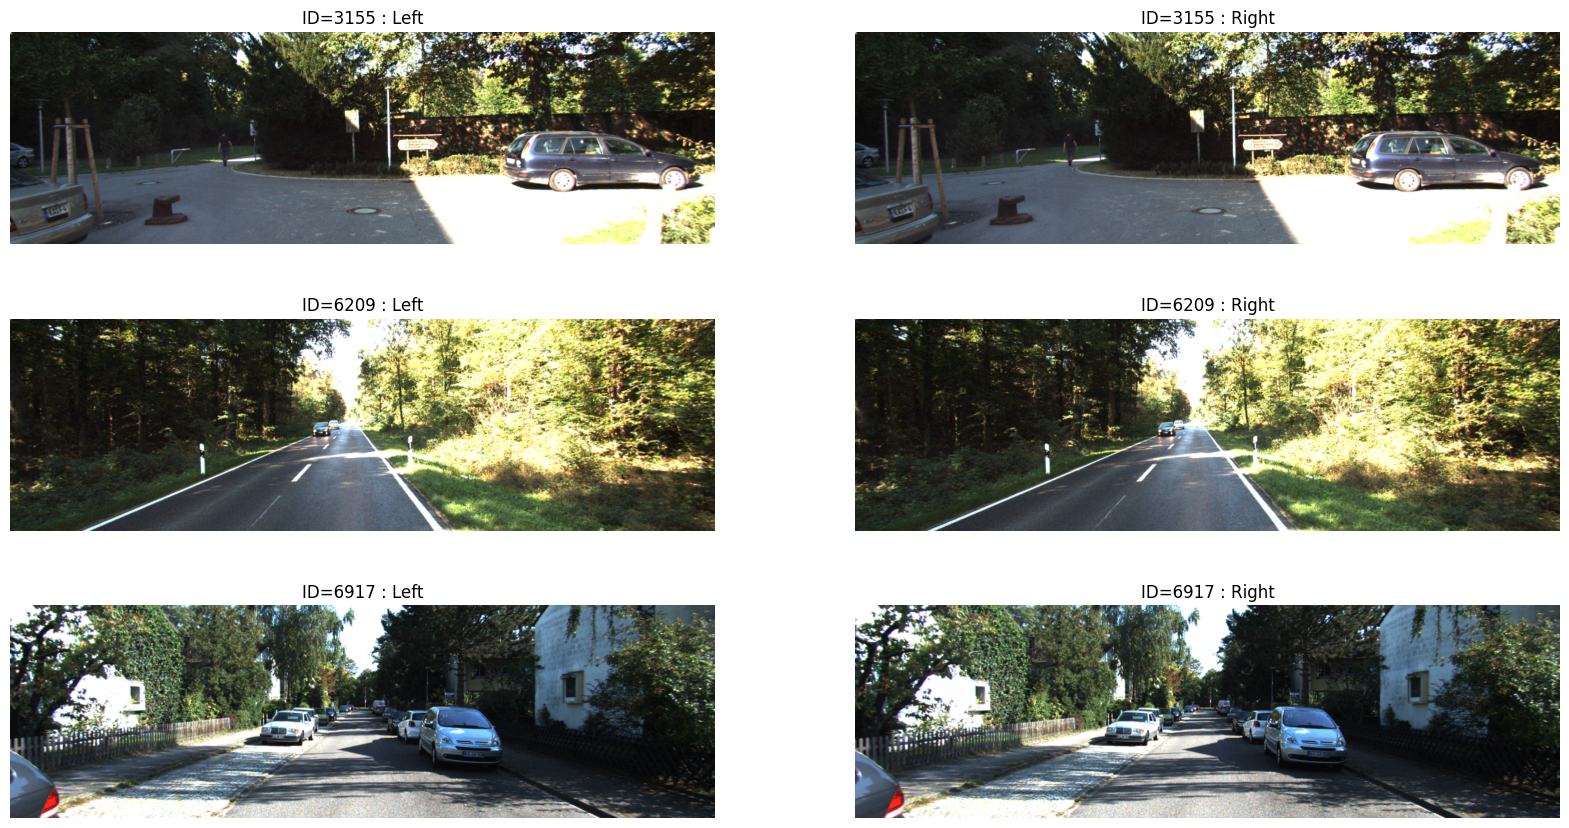

In [4]:
import random
random.seed(0)
image_num = 3
file_ids = sorted(random.sample(range(0, len(file_paths_img_left)-1), image_num))

print(f'file_ids = {file_ids}')

plt.figure(figsize=(20,18))

for i, file_id in enumerate(file_ids):    
    # laod image
    img_left = cv2.imread(file_paths_img_left[file_id])
    img_right = cv2.imread(file_paths_img_right[file_id])
    
    # transform bgr to rgb
    img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2RGB)
    img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2RGB)
    
    # show images
    plt.subplot(5,2,2*i+1)
    plt.imshow(img_left)
    plt.title(f'ID={file_id} : Left')
    plt.axis('off')
    
    plt.subplot(5,2,2*i+2)
    plt.imshow(img_left)
    plt.title(f'ID={file_id} : Right')
    plt.grid()
    plt.axis('off')
    

### 1.2. Read a KITTI calibration parameters

In [5]:
def printDict(dict):
    for key, value in dict.items():
        print(f'\n{key} = ')
        print(f'{value}')

In [6]:
from stereo_camera_utility import readObjectCalibFile
calib_params = readObjectCalibFile(f'{top_dir_object}/calib/000000.txt')
printDict(calib_params)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.

P0 = 
[[707.0493   0.     604.0814   0.    ]
 [  0.     707.0493 180.5066   0.    ]
 [  0.       0.       1.       0.    ]]

P1 = 
[[ 707.0493    0.      604.0814 -379.7842]
 [   0.      707.0493  180.5066    0.    ]
 [   0.        0.        1.        0.    ]]

P2 = 
[[ 7.070493e+02  0.000000e+00  6.040814e+02  4.575831e+01]
 [ 0.000000e+00  7.070493e+02  1.805066e+02 -3.454157e-01]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  4.981016e-03]]

P3 = 
[[ 7.070493e+02  0.000000e+00  6.040814e+02 -3.341081e+02]
 [ 0.000000e+00  7.070493e+02  1.805066e+02  2.330660e+00]
 [ 0.000000e+00  0.000000e+00  1.000000e+00  3.201153e-03]]

R0_rect = 
[[ 0.9999128   0.01009263 -0.00851193]
 [-0.01012729  0.9999406  -0.00403767]
 [ 0.00847068  0.00412352  0.9999556 ]]

Tr_velo_to_cam = 
[[ 0.00692796 -0.9999722  -0.00275783 -0.02457729]

### 1.3. Get Intrinsic and Extrinsic Matrix from Projection Matrix

In [7]:
K_left, R_left, t_left, _, _, _, _ = cv2.decomposeProjectionMatrix(calib_params['P2'])
t_left /= t_left[3]
print(f'K_left = \n{K_left}\n')
print(f'R_left = \n{R_left}\n')
print(f't_left = \n{t_left}\n')

K_left = 
[[707.0493   0.     604.0814]
 [  0.     707.0493 180.5066]
 [  0.       0.       1.    ]]

R_left = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_left = 
[[-0.06046166]
 [ 0.00176016]
 [-0.00498102]
 [ 1.        ]]



In [8]:
K_right, R_right, t_right, _, _, _, _ = cv2.decomposeProjectionMatrix(calib_params['P3'])
t_right /= t_right[3]
print(f'K_right = \n{K_right}\n')
print(f'R_right = \n{R_right}\n')
print(f't_right = \n{t_right}\n')

K_right = 
[[707.0493   0.     604.0814]
 [  0.     707.0493 180.5066]
 [  0.       0.       1.    ]]

R_right = 
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

t_right = 
[[ 0.47527359]
 [-0.00247908]
 [-0.00320115]
 [ 1.        ]]



### 1.4. Get F (= Fundamental Matrix) to calculate epipolar lines

In [9]:
t_rel = t_right - t_left
t_rel = t_rel.flatten()
print(f't_rel = {t_rel}')

T_x = np.array([
    [0, -t_rel[2], t_rel[1]],
    [t_rel[2], 0, -t_rel[0]],
    [-t_rel[1], t_rel[0], 0]
])

F = np.linalg.inv(K_right).T @ T_x @ R_right @ np.linalg.inv(K_left)
print(f'F = {F}')


t_rel = [ 0.53573524 -0.00423924  0.00177986  0.        ]
F = [[ 0.00000000e+00 -3.56030482e-09 -5.35302167e-06]
 [ 3.56030482e-09  0.00000000e+00 -7.59856353e-04]
 [ 5.35302167e-06  7.59856353e-04  0.00000000e+00]]


### 1.5. Calculate Epipolar lines of KITTI dataset
- The inclination of epipolar lines of KITTI is about 0.007.
- So, we do not need to calibrate these files.

line: ax+by+c = 0 // average of -a/b = -0.00742


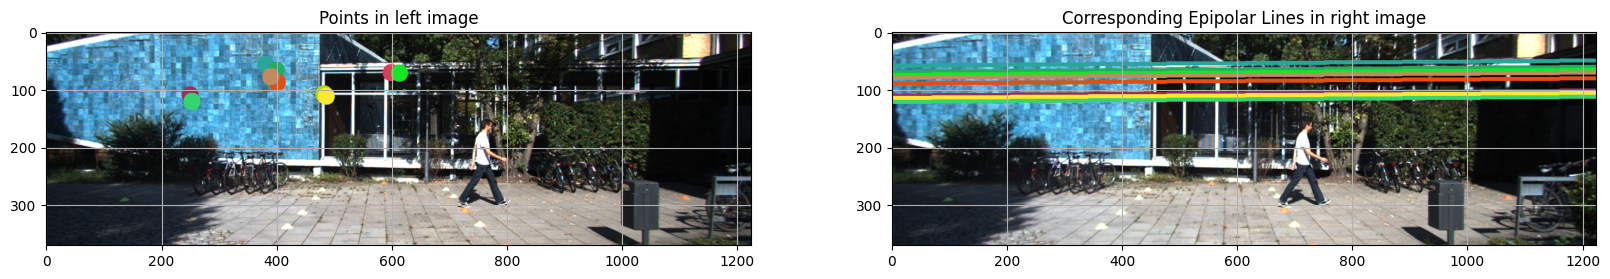

In [10]:
from stereo_camera_utility import drawEpipolarLines

file_id = 0
img_left_bgr = cv2.imread(file_paths_img_left[file_id])
img_right_bgr = cv2.imread(file_paths_img_right[file_id])

img_left_rgb = cv2.cvtColor(img_left_bgr, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2RGB)

drawEpipolarLines(img_right_bgr.copy(), img_left_bgr.copy(), F, top_k=10)

line: ax+by+c = 0 // average of -a/b = -0.00714


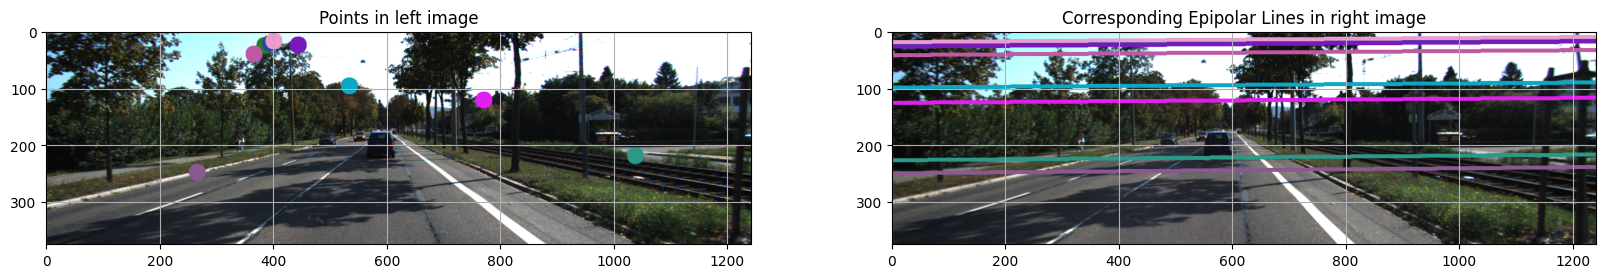

In [11]:
file_id = 7
img_left_bgr = cv2.imread(file_paths_img_left[file_id])
img_right_bgr = cv2.imread(file_paths_img_right[file_id])

img_left_rgb = cv2.cvtColor(img_left_bgr, cv2.COLOR_BGR2RGB)
img_right_rgb = cv2.cvtColor(img_right_bgr, cv2.COLOR_BGR2RGB)

drawEpipolarLines(img_right_bgr.copy(), img_left_bgr.copy(), F, top_k=10)

## 2. Calculate Disparity Maps

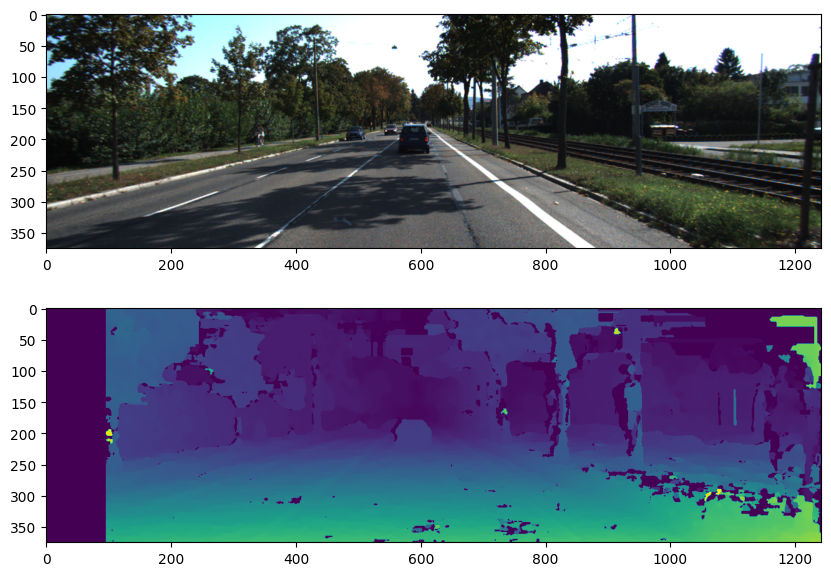

In [12]:
from stereo_camera_utility import calcDisparity

disparity_map = calcDisparity(img_left_bgr, 
                              img_right_bgr, 
                              matcher="stereo_sgbm", 
                              num_disparities=6*16,  # 16*13, 
                              block_size=11,  # 9, 
                              window_size=6  # 9
                              )

plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.imshow(img_left_rgb)

plt.subplot(2,1,2)
plt.imshow(disparity_map)

## 3. Calculate Depth Map

$
Z = \frac{f \cdot b}{x_L - x_R} = \frac{f \cdot b}{disparity}
$

- f = focal length
- b = baseline

In [13]:
def calcDepthMap(disparity_left, focal_length, baseline):
    # Replace all instances of 0 and -1 disparity with a small minimum value (to avoid div by 0 or negatives)
    disparity_left[disparity_left==0] = 0.1
    disparity_left[disparity_left==-1] = 0.1
    
    # Initialize the depth map to match the size of the disparity map
    depth_map = np.ones(disparity_left.shape, np.single)
    
    # Calculate disparity map
    depth_map[:] = focal_length * baseline / disparity_left[:]
    
    return depth_map

Text(0.5, 1.0, 'Depth Map')

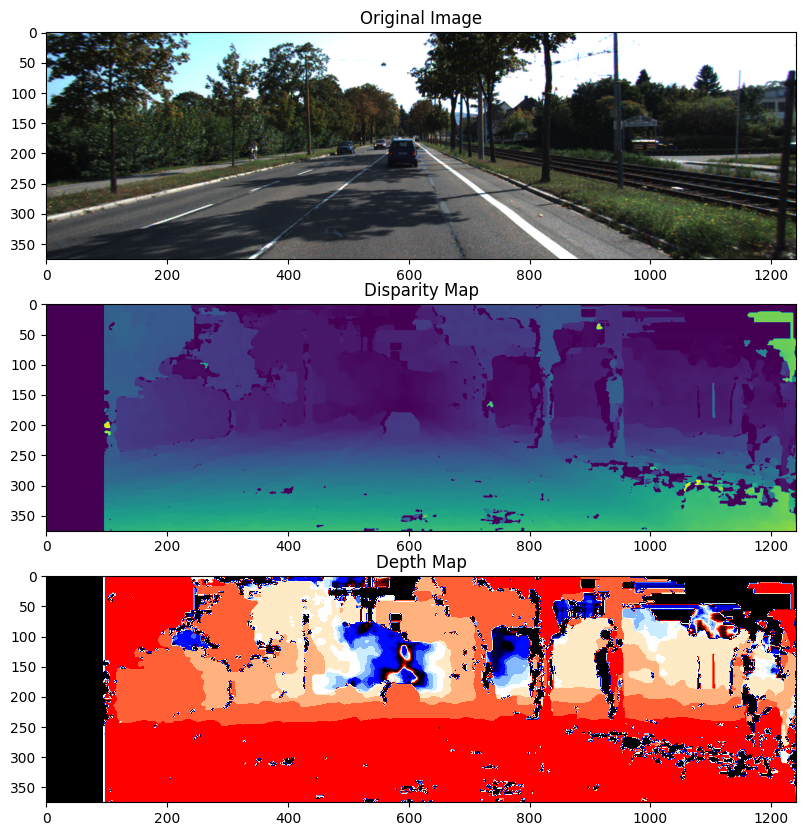

In [14]:
# focal length
focal_length = K_left[0,0]

# baseline
baseline = abs(t_left[0] - t_right[0])
    
depth_map_left = calcDepthMap(disparity_map, focal_length, baseline)

fig, axes = plt.subplots(3,1, figsize=(10,10))

axes[0].imshow(img_left_rgb)
axes[0].set_title('Original Image')

axes[1].imshow(disparity_map)
axes[1].set_title('Disparity Map')

axes[2].imshow(depth_map_left, cmap='flag')
axes[2].set_title('Depth Map')

## 4. Get the depth (= distance ) of Objects

### 4.1. Find the Object Bounding Boxes with YOLO

In [15]:
#!sudo pip install ultralytics #packages installed for me: ultralytics-8.3.51 ultralytics-thop-2.0.13

In [16]:
#!wget https://stereo-vision.s3.eu-west-3.amazonaws.com/yolo11n.pt  #download yolo11n.pt
#!mv ./yolo11n.pt ./models/

In [17]:
import ultralytics
from ultralytics import YOLO
import time
import torch

# load a model
model = YOLO('./models/yolo11n.pt')

print(model.overrides) 
print("Ultralytics version:", ultralytics.__version__)

{'task': 'detect', 'data': '/usr/src/ultralytics/ultralytics/cfg/datasets/coco.yaml', 'imgsz': 640, 'single_cls': False, 'model': './models/yolo11n.pt'}
Ultralytics version: 8.3.171


In [18]:
# Try using GPU
try:
    device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    model.to(device)
except RuntimeError as e:
    device = 'cpu'
    model.to(device)
finally:
    print(f'device = {device}')

device = cpu


/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [19]:
def detectObstacles(img, model, device):
    h, w, _ = img.shape
    results = model.predict(img, device=device)
    result = results[0]  # get prediction result for the first image.
    boxes = result.boxes  # Boxes object for bounding box outputs
    # masks = result.masks  # Masks object for segmentation masks outputs
    # keypoints = result.keypoints  # Keypoints object for pose outputs
    # probs = result.probs  # Probs object for classification outputs
    # obb = result.obb # Oriented boxes object for OBB outputs
    
    # Get person or car
    boxes_filter = []
    for box in boxes:
        object_type = result.names[int(box.cls[0])]
        if object_type=='person' or object_type=='car':
            boxes_filter.append(True)
        else:
            boxes_filter.append(False)
            
    pred_classes = []
    for label in boxes.cls[boxes_filter]:
        pred_classes.append(result.names[int(label)])
        
    # xywhn: 各バウンディングボックスを [center_x, center_y, width, height] 形式で 
    # 画像サイズで割った正規化値として返します
    pred_bboxes = boxes.xywhn[boxes_filter]
    pred_bboxes[:, 0] *= w # ratio to pixel
    pred_bboxes[:, 1] *= h # ratio to pixel
    pred_bboxes[:, 2] *= w # ratio to pixel
    pred_bboxes[:, 3] *= h # ratio to pixel
    pred_conf = boxes.conf[boxes_filter]
    return pred_bboxes, pred_classes, pred_conf

print(f'img_left_rgb.shape = {img_left_rgb.shape}')

pred_bboxes, pred_classes, pred_conf = detectObstacles(img_left_bgr, model, device)

img_left_rgb.shape = (375, 1242, 3)

0: 224x640 3 cars, 109.0ms
Speed: 2.9ms preprocess, 109.0ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)


In [20]:
print(f'pred_bboxes = \n{pred_bboxes}\n')
print(f'pred_classes = \n{pred_classes}\n')
print(f'pred_conf = \n{pred_conf}\n')

pred_bboxes = 
tensor([[589.9052, 197.7610,  50.3771,  50.2695],
        [553.4803, 184.4276,  25.5297,  18.8811],
        [497.2725, 192.1903,  31.1241,  21.1207]])

pred_classes = 
['car', 'car', 'car']

pred_conf = 
tensor([0.5975, 0.5803, 0.4628])



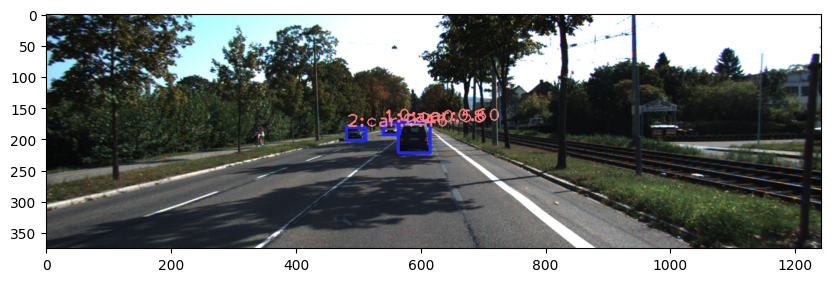

In [21]:
def drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_ori):
    rectangle_thickness = 3
    text_thickness = 2
    img = img_ori.copy()
    h, w, _ = img.shape
    counter = 0
    for box, cls, conf in zip(pred_bboxes, pred_classes, pred_conf):
        x1 = int(box[0] - box[2]*0.5) # left : center_x - width /2
        y1 = int(box[1] - box[3]*0.5) # top : center_y - height /2
        x2 = int(box[0] + box[2]*0.5) # right : center_x + width/2
        y2 = int(box[1] + box[3]*0.5) # bottom : center_y + height/2
        objecttype = cls
        
        if objecttype=='person' or objecttype=='car':
            cv2.rectangle(img, (x1,y1),
                          (x2,y2), (30, 40, 255), rectangle_thickness)
            
            # 変換を修正
            #confidence = conf.numpy().round(2)
            confidence = conf.cpu().numpy().round(2)
            
            cv2.putText(img, 
                        f"{counter}:{objecttype}:{confidence:.2f}",
                        (x1, y1),
                        cv2.FONT_HERSHEY_PLAIN, 
                        fontScale=2, 
                        color=(255, 125, 125), 
                        thickness=text_thickness)
            counter +=1
    return img

img_with_prediction = drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_left_rgb)

plt.figure(figsize=(10,5))
plt.imshow(img_with_prediction)
        

### 4.2 Get Distances

In [22]:
def findDistances(depth_map, pred_bboxes, method="center"):
    """
    Go through each bounding box and take a point in the corresponding depth map.
    It can be:
    * The Center of the box
    * The average value
    * The minimum value (closest point)
    * The median of the values
    """
    depth_list = []
    
    for box in pred_bboxes:
        x1 = int(box[0] - box[2]*0.5) # center_x - width /2
        y1 = int(box[1] - box[3]*0.5) # center_y - height /2
        x2 = int(box[0] + box[2]*0.5) # center_x + width/2
        y2 = int(box[1] + box[3]*0.5) # center_y + height/2
        #print(np.array([x1, y1, x2, y2]))
        obstacle_depth = depth_map[y1:y2, x1:x2]
        if method=="closest":
            depth_list.append(obstacle_depth.min()) # take the closest point in the box
        elif method=="average":
            depth_list.append(np.mean(obstacle_depth)) # take the average
        elif method=="median":
            depth_list.append(np.median(obstacle_depth)) # take the median
        else:
            depth_list.append(depth_map[int(box[1])][int(box[0])]) # take the center
    return depth_list

depth_list = findDistances(depth_map_left, pred_bboxes, method="center")
print(depth_list)

[23.582333, 61.218784, 46.981857]


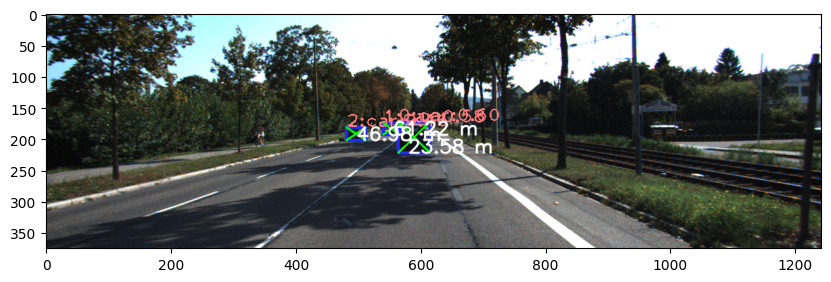

In [23]:
def addDepthToImage(img_ori, depth_list, pred_bboxes):
    img = img_ori.copy()
    
    for i, distance in enumerate(depth_list):
        x1 = int(pred_bboxes[i][0] - pred_bboxes[i][2]/2)
        x2 = int(pred_bboxes[i][0] + pred_bboxes[i][2]/2)
        y0 = int(pred_bboxes[i][1])
        y1 = int(pred_bboxes[i][1] - pred_bboxes[i][3]/2)
        y2 = int(pred_bboxes[i][1] + pred_bboxes[i][3]/2)
        cv2.line(img, (x1, y1), (x2, y2), (0,255,0), 2)
        cv2.line(img, (x2, y1), (x1, y2), (0,255,0), 2)
        
        text_color = (255,255,255)  #(210, 105, 30)  # (255,255,255)
        cv2.putText(img, 
                    f'{distance: .2f} m', 
                    (x1, y2), 
                    cv2.FONT_HERSHEY_SIMPLEX, 
                    fontScale=1, 
                    color=text_color, 
                    thickness=2,
                    lineType=cv2.LINE_AA)
    return img


img_with_depth = addDepthToImage(img_with_prediction, depth_list, pred_bboxes)
plt.figure(figsize=(10,5))
plt.imshow(img_with_depth)


### 4.3. Check Accuracy of Depth Estimation

In [24]:
# Read a ground truth file of KITTI
def readObjectLabelFile(file_path):
    def read_line(line):
        params = line.split()
        print(f'params = {params}')
        label = {}
        label['type'] = params[0]
        label['truncated'] = float(params[1])  # 0.0=完全に写っている
        label['occluded'] = float(params[2])  # 0=遮蔽なし
        label['alpha'] = float(params[3])  # オブジェクトのYaw角(相対)
        label['bbox'] = [float(v) for v in params[4:8]]  # bbox [pixel]
        label['dim'] = [float(v) for v in params[8:11]] # height, width, length [m]
        label['loc'] = [float(v) for v in params[11:14]]  # x, y, z [m]
        label['rot_y'] = float(params[14])  # オブジェクトのYaw角(絶対)
        return label
    #
    labels = []
    #
    with open(file_path, 'r') as f:
        for line in f:
            labels.append(read_line(line))
    return labels

file_id = 7
file_paths_label_left = sorted(glob(f'{top_dir_object}/label_2/*.txt'))
file_path_label_left = file_paths_label_left[file_id]
print(file_path_label_left)
labels = readObjectLabelFile(file_path_label_left)

for label in labels:
    print(label)

./KITTI/object/training/label_2/000007.txt
params = ['Car', '0.00', '0', '-1.56', '564.62', '174.59', '616.43', '224.74', '1.61', '1.66', '3.20', '-0.69', '1.69', '25.01', '-1.59']
params = ['Car', '0.00', '0', '1.71', '481.59', '180.09', '512.55', '202.42', '1.40', '1.51', '3.70', '-7.43', '1.88', '47.55', '1.55']
params = ['Car', '0.00', '0', '1.64', '542.05', '175.55', '565.27', '193.79', '1.46', '1.66', '4.05', '-4.71', '1.71', '60.52', '1.56']
params = ['Cyclist', '0.00', '0', '1.89', '330.60', '176.09', '355.61', '213.60', '1.72', '0.50', '1.95', '-12.63', '1.88', '34.09', '1.54']
params = ['DontCare', '-1', '-1', '-10', '753.33', '164.32', '798.00', '186.74', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10']
params = ['DontCare', '-1', '-1', '-10', '738.50', '171.32', '753.27', '184.42', '-1', '-1', '-1', '-1000', '-1000', '-1000', '-10']
{'type': 'Car', 'truncated': 0.0, 'occluded': 0.0, 'alpha': -1.56, 'bbox': [564.62, 174.59, 616.43, 224.74], 'dim': [1.61, 1.66, 3.2], 'loc'

In [25]:
# Compair Estimation and Ground truth
def comparePredictionAndLabel(pred_bboxes, pred_classes, pred_depths, labels, ):
    label_depths = - np.ones((len(pred_bboxes,)))
    for i, (pred_bbox, pred_class, pred_depth) in enumerate(zip(pred_bboxes, pred_classes, pred_depths)):
        for label in labels:
            if label["type"].lower() == pred_class.lower():
                # pos of predition
                center_x = pred_bbox[0]
                center_y = pred_bbox[1]
                
                # if prediction pos is in the bbox of label, get depth info.
                if (label['bbox'][0] < center_x < label['bbox'][2] and 
                    label['bbox'][1] < center_y < label['bbox'][3]):
                    label_depths[i] = label['loc'][2]
            if label_depths[i] > 0:
                break
    return label_depths

label_depths = comparePredictionAndLabel(pred_bboxes, pred_classes, depth_list, labels)
depth_diff = np.array(depth_list) - label_depths
print(f'depth : ground truth  = {label_depths}')
print(f'depth : estimation    = {depth_list}')
print(f'depth diff            = {depth_diff}')
                       

depth : ground truth  = [      25.01       60.52       47.55]
depth : estimation    = [23.582333, 61.218784, 46.981857]
depth diff            = [    -1.4277     0.69878    -0.56814]


In [26]:
def objectDetectionPipeline(file_path_img_left, file_path_img_right, p_left, p_right, model, device):
    # Load images
    img_bgr_left = cv2.imread(file_path_img_left)
    img_bgr_right = cv2.imread(file_path_img_right)
    img_rgb_left = cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2RGB)
    
    # BGR to GRAY
    img_gray_left = cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2GRAY)
    img_gray_right = cv2.cvtColor(img_bgr_right, cv2.COLOR_BGR2GRAY)
    
    # Compute the diparity map
    disparity_map = calcDisparity(img_gray_left, 
                                  img_gray_right, 
                                  matcher="stereo_sgbm",
                                  num_disparities=112,
                                  block_size=5,
                                  window_size=7)
    normalized_disparity = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype("uint8")
    colormapped_disparity = cv2.applyColorMap(normalized_disparity, cv2.COLORMAP_JET)
    
    # Get the calibration parameters
    K_left, R_left, t_left, _, _, _, _ = cv2.decomposeProjectionMatrix(p_left)
    K_right, R_right, t_right, _, _, _, _ = cv2.decomposeProjectionMatrix(p_right)
    
    # Compute a Depth Mpa
    focal_length = K_left[0,0]
    baseline = abs(t_left[0] - t_right[0])
    depth_map = calcDepthMap(disparity_map.copy(), focal_length, baseline)
    
    # Detect objects in 2D
    pred_bboxes, pred_classes, pred_conf = detectObstacles(img_bgr_left, model, device)
    
    # Estimate Depth
    depth_list = findDistances(depth_map, pred_bboxes)
    
    # Add prediction results to the image
    img_with_pred = drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, img_rgb_left)
    img_with_pred = addDepthToImage(img_with_pred, depth_list, pred_bboxes)
    #
    disparity_with_pred = drawDetectedObstacles(pred_bboxes, pred_classes, pred_conf, colormapped_disparity)
    disparity_with_pred = addDepthToImage(disparity_with_pred, depth_list, pred_bboxes)
    
    # Stack 2 images
    # stacked_img = np.vstack([img_with_pred, disparity_with_pred])
    
    return (img_with_pred, disparity_with_pred, img_rgb_left, disparity_map)


0: 224x640 3 cars, 87.9ms
Speed: 1.5ms preprocess, 87.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
img shape = (375, 1242, 3)


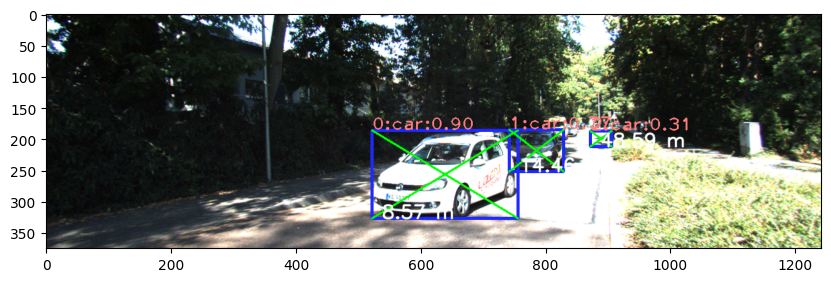

In [27]:
file_id = 7479
detection_res = objectDetectionPipeline(file_paths_img_left[file_id], 
                                        file_paths_img_right[file_id], 
                                        calib_params['P2'], 
                                        calib_params['P3'], 
                                        model, 
                                        device)
plt.figure(figsize=(10,5))
plt.imshow(detection_res[0])
plt.savefig(f'./output/stereo_depth_estimation_{file_id}.png')
print(f'img shape = {detection_res[2].shape}')

## 5. 3D Reconstruction
- With stereo camera images, we reconstruct 3D points.
- OpenCV uses the Q Matrix to get 3D point cloud.

$
Q = \begin{bmatrix}
1 & 0 & 0 & -c_x \\
0 & 1 & 0 & -c_y \\
0 & 0 & 0 & f \\
0 & 0 & -\frac{1}{T_x} & \frac{c_x - c'_x}{T_x}
\end{bmatrix}
$

- u, v :
    - 2D pose in the pixel coordinate
- d : 
    - disparity
- X, Y, Z, W : 
    - 3D pose in the homologous coordinate

$
Q \cdot \begin{bmatrix}
u \\
v \\
d \\
1
\end{bmatrix}
= \begin{bmatrix}
u - c_x \\
v - c_y \\
f \\
\frac{c_x - c'_x - d}{T_x}
\end{bmatrix}
= \begin{bmatrix}
X \\
Y \\
Z \\
W
\end{bmatrix}
$

- X', Y', Z' : 
    - 3D pose in the real-world coordinate

$
(X', Y', Z') = \left(\frac{X}{W}, \frac{Y}{W}, \frac{Z}{W}\right)
$

In [28]:
def calcQMatrix(K_left, K_right, R_stereo, t_stereo, img_size):
    # Init Q
    Q = np.zeros((4,4))
    
    # Calc Q
    cv2.stereoRectify(cameraMatrix1 = K_left,
                      cameraMatrix2 = K_right,
                      distCoeffs1= 0,
                      distCoeffs2=0,
                      imageSize=img_size,
                      R = R_stereo,
                      T = t_stereo,
                      R1 = None, R2 = None,
                      P1 = None, P2 = None, 
                      Q = Q)
    return Q

# According to KITTI configuration.
R_stereo = np.eye(3)
t_stereo = np.array([0.51, 0.0, 0.0])

# 
img_size = (detection_res[2].shape[1], detection_res[2].shape[0])
Q = calcQMatrix(K_left, K_right, R_stereo, t_stereo, img_size)

print(Q)
    

[[          1           0           0     -604.08]
 [          0           1           0     -180.51]
 [          0           0           0      707.05]
 [          0           0     -1.9608           0]]


In [ ]:
def get3dPointsAndColors(disparity_map, Q, img_rgb):
    # Get 3D points
    points = cv2.reprojectImageTo3D(disparity_map.copy(), Q)
    
    # Reflect X axis
    reflext_matrix = np.identity(3)
    reflext_matrix[0] *= -1
    points = np.matmul(points, reflext_matrix)
    
    # Get colors for each points
    mask = (disparity_map > 0) & np.isfinite(disparity_map)    
    points = points[mask]
    colors = img_rgb[mask]
    colors = colors.reshape(-1,3)
    
    return points, colors

In [30]:
from stereo_camera_utility import write_ply

file_id = 7479
img_bgr_left = cv2.imread(file_paths_img_left[file_id])
img_bgr_right = cv2.imread(file_paths_img_right[file_id])
img_rgb_left = cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2RGB)
disparity_map = calcDisparity(cv2.cvtColor(img_bgr_left, cv2.COLOR_BGR2GRAY), 
                              cv2.cvtColor(img_bgr_right, cv2.COLOR_BGR2GRAY), 
                              matcher="stereo_sgbm",
                              num_disparities=112,
                              block_size=5,
                              window_size=7)
points3D, colors3D = get3dPointsAndColors(disparity_map, Q, img_rgb_left)
file_path_ply = './output/stereo_point_cloud.ply'
write_ply(file_path_ply, points3D, colors3D)

<ipython-input-29-3e2a3145fd17>:8: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflext_matrix)


mask.shape = (375, 1242)
dispairty_map.shape = (375, 1242)
points.shape = (375, 1242, 3)


In [31]:
import open3d as o3d
#from stereo_camera_utility import savePointCloudAsImage

def savePointCloudAsImage(pcd, file_path_save, width=1024, height=768):
    # Create the visualizer
    vis = o3d.visualization.Visualizer()
    
    if width is None or height is None:
        vis.create_window(visible=True)
    else:
        vis.create_window(visible=True, width=width, height=height) # vis.create_window(visible=False)
    #

    # Add geometry (e.g., point cloud)
    vis.add_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    # Set the view parameters (camera settings)
    view_control = vis.get_view_control()
    view_control.set_zoom(0.01)
    view_control.set_front([0, 0.01, 5])
    view_control.set_lookat([0, 0.1, -10])
    view_control.set_up([0, 0, -1])

    # Alternative Camera Angle
    #view_control.set_front([ 0.27028868132726824, -0.0036027827686225091, 0.96277258410420508 ])
    #view_control.set_up([ -0.01446335938247148, 0.99986496068000874, 0.0078020279247221856 ])

    # Update the visualization to reflect changes
    vis.update_geometry(pcd)
    vis.poll_events()
    vis.update_renderer()

    # Save the screenshot
    vis.capture_screen_image(file_path_save)

    # Close the visualizer window
    vis.destroy_window()    

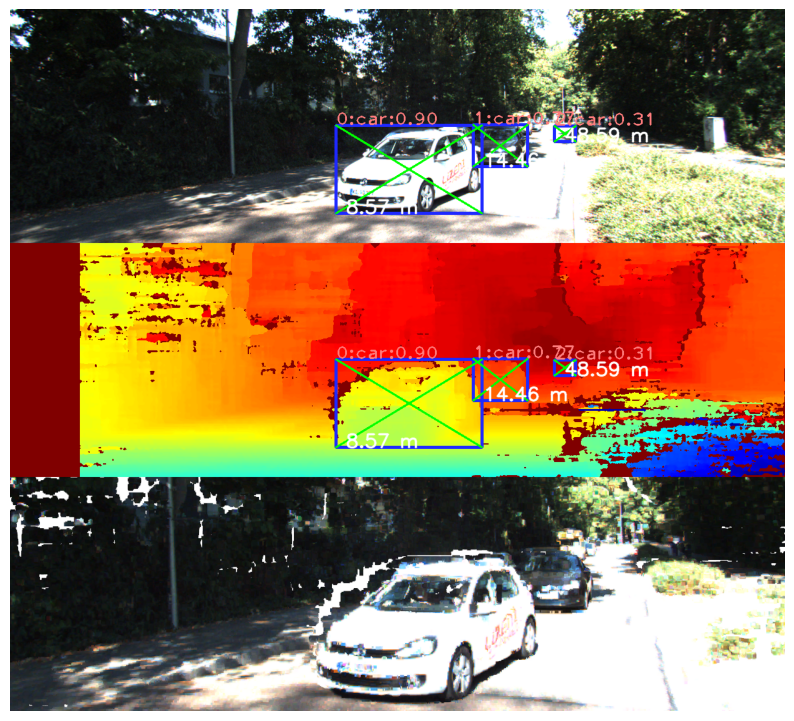

In [32]:
# Read ply File as pcd
pcd = o3d.io.read_point_cloud(file_path_ply)

# Save pcd as an image file
file_path_pcd_img = './output/stereo_point_cloud.png'
savePointCloudAsImage(pcd, file_path_pcd_img, width=1920, height=1016)

# Show point cloud
img_pcd = cv2.imread(file_path_pcd_img)
img_pcd = cv2.cvtColor(img_pcd, cv2.COLOR_BGR2RGB)

# Crop image
pcd_height, pcd_width = img_pcd.shape[:2]
target_width, target_height = img_size
y_offset = 80
y_min = max(int(pcd_height/2 - target_height/2), 0) + y_offset
y_max = y_min + target_height
x_min = max(int(pcd_width/2 - target_width/2), 0)
x_max = x_min + target_width
img_pcd_cropped = img_pcd[y_min:y_max, x_min:x_max, :]

# Stack images: RGB, Disparity, 3D-Point-Cloud
stacked_img = np.vstack([detection_res[0], detection_res[1], img_pcd_cropped])

plt.figure(figsize=(10,15))
plt.imshow(stacked_img)
plt.axis('off')
plt.savefig('./output/stereo_point_cloud_stacked.png', bbox_inches='tight', pad_inches=0)



0: 224x640 14 cars, 69.0ms
Speed: 1.4ms preprocess, 69.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (375, 1242)
dispairty_map.shape = (375, 1242)
points.shape = (375, 1242, 3)


<ipython-input-29-3e2a3145fd17>:8: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflext_matrix)


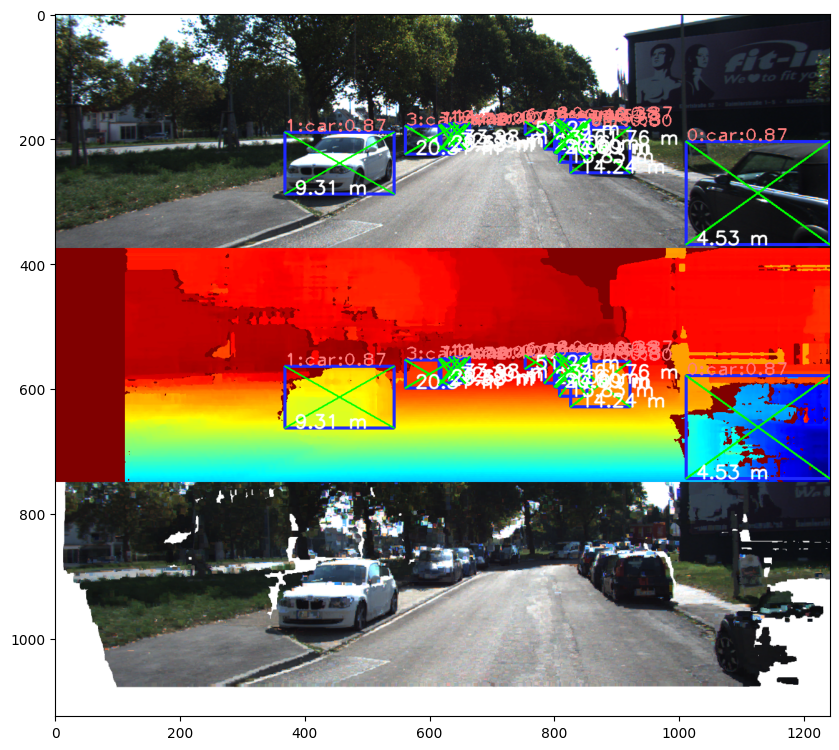

In [33]:
def depthEstimationPipeline(file_path_img_left, file_path_img_right, file_id, p_left, p_right, Q, model, device):
    save_name_head = f'./output/stereo_pcd_{file_id: 03d}'
    
    # Detect Object and Get Depth
    # detect_res = (img_with_pred, disparity_with_pred, img_rgb_left, disparity_map)
    (img_with_pred, disparity_with_pred, img_rgb_left, disparity_map) = objectDetectionPipeline(
        file_path_img_left, file_path_img_right, p_left, p_right, model, device)
    
    # Create Point Cloud
    points3D, colors3D = get3dPointsAndColors(disparity_map, Q, img_rgb_left)
    file_path_ply = f'{save_name_head}.ply'
    write_ply(file_path_ply, points3D, colors3D)
    
    # Read ply File as pcd
    pcd = o3d.io.read_point_cloud(file_path_ply)

    # Save pcd as an image file
    file_path_pcd_img = f'{save_name_head}.png'
    savePointCloudAsImage(pcd, file_path_pcd_img, width=1920, height=1016)

    # load point cloud image
    img_pcd = cv2.imread(file_path_pcd_img)
    img_pcd = cv2.cvtColor(img_pcd, cv2.COLOR_BGR2RGB)

    # Crop image
    pcd_height, pcd_width = img_pcd.shape[:2]
    target_height, target_width = img_with_pred.shape[:2]
    y_offset = 80
    y_min = max(int(pcd_height/2 - target_height/2), 0) + y_offset
    y_max = y_min + target_height
    x_min = max(int(pcd_width/2 - target_width/2), 0)
    x_max = x_min + target_width
    img_pcd_cropped = img_pcd[y_min:y_max, x_min:x_max, :]

    # Stack images: RGB, Disparity, 3D-Point-Cloud
    stacked_img = np.vstack([img_with_pred, disparity_with_pred, img_pcd_cropped])
    
    return stacked_img


# Check the pipeline
file_id = 10 # 1000  #  7479
file_path_img_left = file_paths_img_left[file_id]
file_path_img_right = file_paths_img_right[file_id]
p_left = calib_params['P2']
p_right = calib_params['P3']
stacked_img = depthEstimationPipeline(file_path_img_left, file_path_img_right, file_id, p_left, p_right, Q, model, device)
plt.figure(figsize=(10,15))
plt.imshow(stacked_img)

## 7. Video Depth Estimation
- Time series image files are stored in raw dataset.

In [34]:
import imageio
from tqdm import tqdm

In [47]:
# raw
top_dir_raw = './KITTI/raw_data/2011_09_30/2011_09_30_drive_0016_sync'
file_paths_raw_img_left = sorted(glob(f'{top_dir_raw}/image_02/data/*.png'))
file_paths_raw_img_right = sorted(glob(f'{top_dir_raw}/image_03/data/*.png'))

frames1 = []
max_frame = 250
do_resize = True

for file_id, (file_path_img_left, file_path_img_right) in tqdm(
        enumerate(zip(file_paths_raw_img_left, file_paths_raw_img_right)),
        total=len(file_paths_raw_img_left),
        desc="Generating GIF frames"):
    
    # Create 1-frame
    frame = depthEstimationPipeline(file_path_img_left, file_path_img_right, file_id, p_left, p_right, Q, model, device)
    
    # resize
    if do_resize:
        new_size = (int(frame.shape[0]/2), int(frame.shape[1]/2)  )
        frame = cv2.resize(frame, new_size)
    
    # save
    frames1.append(frame)
        
    if file_id > max_frame:
        break    

# save to file    
file_path_movie1 = './output/stereo_4d_perception_2011_09_30_drive_0016.gif'
imageio.mimsave(file_path_movie1, frames1, fps=10, loop=0)  # fpsは調整可能    

Generating GIF frames:   0%|          | 0/279 [00:00<?, ?it/s]


0: 224x640 4 cars, 703.4ms
Speed: 77.4ms preprocess, 703.4ms inference, 32.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   0%|          | 1/279 [00:05<23:17,  5.03s/it]


0: 224x640 5 cars, 110.2ms
Speed: 3.0ms preprocess, 110.2ms inference, 3.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


<ipython-input-29-3e2a3145fd17>:8: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflext_matrix)
Generating GIF frames:   1%|          | 2/279 [00:09<20:42,  4.48s/it]


0: 224x640 3 cars, 83.6ms
Speed: 1.9ms preprocess, 83.6ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   1%|          | 3/279 [00:12<18:59,  4.13s/it]


0: 224x640 4 cars, 1 fire hydrant, 89.8ms
Speed: 1.8ms preprocess, 89.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   1%|▏         | 4/279 [00:17<19:08,  4.18s/it]


0: 224x640 2 cars, 1 traffic light, 1 fire hydrant, 1 stop sign, 80.2ms
Speed: 1.9ms preprocess, 80.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   2%|▏         | 5/279 [00:21<19:19,  4.23s/it]


0: 224x640 2 cars, 108.1ms
Speed: 2.4ms preprocess, 108.1ms inference, 4.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   2%|▏         | 6/279 [00:24<18:12,  4.00s/it]


0: 224x640 2 cars, 76.5ms
Speed: 1.7ms preprocess, 76.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   3%|▎         | 7/279 [00:28<17:33,  3.87s/it]


0: 224x640 2 cars, 1 stop sign, 77.0ms
Speed: 1.8ms preprocess, 77.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   3%|▎         | 8/279 [00:32<16:58,  3.76s/it]


0: 224x640 2 cars, 78.8ms
Speed: 3.0ms preprocess, 78.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   3%|▎         | 9/279 [00:35<16:34,  3.68s/it]


0: 224x640 2 cars, 78.5ms
Speed: 1.8ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   4%|▎         | 10/279 [00:39<16:08,  3.60s/it]


0: 224x640 2 cars, 75.0ms
Speed: 1.7ms preprocess, 75.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   4%|▍         | 11/279 [00:42<16:04,  3.60s/it]


0: 224x640 2 cars, 78.3ms
Speed: 1.8ms preprocess, 78.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   4%|▍         | 12/279 [00:46<16:05,  3.62s/it]


0: 224x640 2 cars, 81.2ms
Speed: 1.7ms preprocess, 81.2ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   5%|▍         | 13/279 [00:49<16:07,  3.64s/it]


0: 224x640 2 cars, 1 traffic light, 79.0ms
Speed: 1.8ms preprocess, 79.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   5%|▌         | 14/279 [00:53<16:30,  3.74s/it]


0: 224x640 2 cars, 78.7ms
Speed: 1.7ms preprocess, 78.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   5%|▌         | 15/279 [00:57<16:46,  3.81s/it]


0: 224x640 3 cars, 102.8ms
Speed: 2.1ms preprocess, 102.8ms inference, 3.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   6%|▌         | 16/279 [01:01<16:41,  3.81s/it]


0: 224x640 2 cars, 85.2ms
Speed: 1.8ms preprocess, 85.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   6%|▌         | 17/279 [01:05<16:38,  3.81s/it]


0: 224x640 2 cars, 105.0ms
Speed: 2.1ms preprocess, 105.0ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   6%|▋         | 18/279 [01:09<16:14,  3.73s/it]


0: 224x640 2 cars, 79.3ms
Speed: 2.3ms preprocess, 79.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   7%|▋         | 19/279 [01:12<16:13,  3.74s/it]


0: 224x640 2 cars, 80.4ms
Speed: 1.7ms preprocess, 80.4ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   7%|▋         | 20/279 [01:16<16:36,  3.85s/it]


0: 224x640 2 cars, 1 stop sign, 101.7ms
Speed: 1.9ms preprocess, 101.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   8%|▊         | 21/279 [01:20<16:27,  3.83s/it]


0: 224x640 2 cars, 78.9ms
Speed: 2.2ms preprocess, 78.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   8%|▊         | 22/279 [01:24<16:37,  3.88s/it]


0: 224x640 2 cars, 82.1ms
Speed: 1.8ms preprocess, 82.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   8%|▊         | 23/279 [01:28<16:19,  3.83s/it]


0: 224x640 2 cars, 75.1ms
Speed: 1.6ms preprocess, 75.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   9%|▊         | 24/279 [01:32<16:16,  3.83s/it]


0: 224x640 1 car, 107.7ms
Speed: 2.2ms preprocess, 107.7ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   9%|▉         | 25/279 [01:35<16:01,  3.78s/it]


0: 224x640 1 car, 79.3ms
Speed: 3.3ms preprocess, 79.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:   9%|▉         | 26/279 [01:39<15:44,  3.73s/it]


0: 224x640 1 car, 83.2ms
Speed: 2.0ms preprocess, 83.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  10%|▉         | 27/279 [01:43<15:22,  3.66s/it]


0: 224x640 1 car, 82.6ms
Speed: 2.0ms preprocess, 82.6ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  10%|█         | 28/279 [01:46<15:16,  3.65s/it]


0: 224x640 1 car, 78.5ms
Speed: 2.0ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  10%|█         | 29/279 [01:50<15:21,  3.69s/it]


0: 224x640 1 car, 99.1ms
Speed: 1.7ms preprocess, 99.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  11%|█         | 30/279 [01:53<15:06,  3.64s/it]


0: 224x640 1 car, 102.2ms
Speed: 1.8ms preprocess, 102.2ms inference, 3.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  11%|█         | 31/279 [01:57<14:53,  3.60s/it]


0: 224x640 1 car, 82.7ms
Speed: 1.9ms preprocess, 82.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  11%|█▏        | 32/279 [02:00<14:39,  3.56s/it]


0: 224x640 1 car, 107.8ms
Speed: 2.2ms preprocess, 107.8ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  12%|█▏        | 33/279 [02:04<14:46,  3.60s/it]


0: 224x640 1 car, 84.2ms
Speed: 1.9ms preprocess, 84.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  12%|█▏        | 34/279 [02:08<14:54,  3.65s/it]


0: 224x640 1 car, 76.1ms
Speed: 2.0ms preprocess, 76.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  13%|█▎        | 35/279 [02:11<14:40,  3.61s/it]


0: 224x640 1 car, 99.0ms
Speed: 1.9ms preprocess, 99.0ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  13%|█▎        | 36/279 [02:15<14:15,  3.52s/it]


0: 224x640 1 car, 1 truck, 73.8ms
Speed: 2.3ms preprocess, 73.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  13%|█▎        | 37/279 [02:18<14:02,  3.48s/it]


0: 224x640 1 car, 74.7ms
Speed: 1.7ms preprocess, 74.7ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  14%|█▎        | 38/279 [02:21<13:24,  3.34s/it]


0: 224x640 1 car, 72.8ms
Speed: 1.8ms preprocess, 72.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  14%|█▍        | 39/279 [02:24<12:57,  3.24s/it]


0: 224x640 1 car, 99.5ms
Speed: 3.4ms preprocess, 99.5ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  14%|█▍        | 40/279 [02:27<12:45,  3.20s/it]


0: 224x640 1 car, 82.8ms
Speed: 2.0ms preprocess, 82.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  15%|█▍        | 41/279 [02:30<12:26,  3.14s/it]


0: 224x640 1 car, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  15%|█▌        | 42/279 [02:34<12:38,  3.20s/it]


0: 224x640 1 car, 85.9ms
Speed: 1.7ms preprocess, 85.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  15%|█▌        | 43/279 [02:37<13:13,  3.36s/it]


0: 224x640 1 car, 82.3ms
Speed: 1.4ms preprocess, 82.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  16%|█▌        | 44/279 [02:41<13:20,  3.40s/it]


0: 224x640 1 car, 88.0ms
Speed: 1.8ms preprocess, 88.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  16%|█▌        | 45/279 [02:44<13:27,  3.45s/it]


0: 224x640 1 car, 80.7ms
Speed: 1.8ms preprocess, 80.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  16%|█▋        | 46/279 [02:48<13:28,  3.47s/it]


0: 224x640 1 car, 97.5ms
Speed: 1.7ms preprocess, 97.5ms inference, 3.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  17%|█▋        | 47/279 [02:51<13:01,  3.37s/it]


0: 224x640 1 car, 1 truck, 78.2ms
Speed: 1.5ms preprocess, 78.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  17%|█▋        | 48/279 [02:54<12:38,  3.28s/it]


0: 224x640 1 car, 1 truck, 75.9ms
Speed: 1.6ms preprocess, 75.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  18%|█▊        | 49/279 [02:57<12:22,  3.23s/it]


0: 224x640 1 person, 1 car, 77.9ms
Speed: 1.7ms preprocess, 77.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  18%|█▊        | 50/279 [03:01<12:38,  3.31s/it]


0: 224x640 1 car, 81.3ms
Speed: 1.8ms preprocess, 81.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  18%|█▊        | 51/279 [03:04<12:38,  3.32s/it]


0: 224x640 1 person, 1 car, 76.3ms
Speed: 1.8ms preprocess, 76.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  19%|█▊        | 52/279 [03:07<12:24,  3.28s/it]


0: 224x640 1 car, 90.6ms
Speed: 1.8ms preprocess, 90.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  19%|█▉        | 53/279 [03:11<12:19,  3.27s/it]


0: 224x640 1 car, 96.4ms
Speed: 1.5ms preprocess, 96.4ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  19%|█▉        | 54/279 [03:14<12:12,  3.25s/it]


0: 224x640 1 car, 97.1ms
Speed: 3.8ms preprocess, 97.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  20%|█▉        | 55/279 [03:17<12:36,  3.38s/it]


0: 224x640 1 car, 83.3ms
Speed: 2.2ms preprocess, 83.3ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  20%|██        | 56/279 [03:21<12:34,  3.38s/it]


0: 224x640 1 car, 103.2ms
Speed: 2.3ms preprocess, 103.2ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  20%|██        | 57/279 [03:24<12:23,  3.35s/it]


0: 224x640 1 car, 74.9ms
Speed: 1.8ms preprocess, 74.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  21%|██        | 58/279 [03:27<12:18,  3.34s/it]


0: 224x640 1 car, 81.0ms
Speed: 2.2ms preprocess, 81.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  21%|██        | 59/279 [03:30<11:53,  3.24s/it]


0: 224x640 1 car, 79.8ms
Speed: 1.8ms preprocess, 79.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  22%|██▏       | 60/279 [03:34<11:59,  3.29s/it]


0: 224x640 1 car, 94.4ms
Speed: 1.8ms preprocess, 94.4ms inference, 4.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  22%|██▏       | 61/279 [03:37<12:08,  3.34s/it]


0: 224x640 1 car, 80.1ms
Speed: 1.8ms preprocess, 80.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  22%|██▏       | 62/279 [03:41<12:10,  3.37s/it]


0: 224x640 1 car, 73.0ms
Speed: 1.7ms preprocess, 73.0ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  23%|██▎       | 63/279 [03:44<11:53,  3.30s/it]


0: 224x640 1 car, 83.8ms
Speed: 1.9ms preprocess, 83.8ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  23%|██▎       | 64/279 [03:47<12:01,  3.36s/it]


0: 224x640 1 car, 79.8ms
Speed: 1.9ms preprocess, 79.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  23%|██▎       | 65/279 [03:51<11:47,  3.31s/it]


0: 224x640 1 car, 73.3ms
Speed: 1.7ms preprocess, 73.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  24%|██▎       | 66/279 [03:54<11:37,  3.28s/it]


0: 224x640 1 car, 76.2ms
Speed: 2.0ms preprocess, 76.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  24%|██▍       | 67/279 [03:57<11:35,  3.28s/it]


0: 224x640 1 car, 71.8ms
Speed: 1.8ms preprocess, 71.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  24%|██▍       | 68/279 [04:00<11:28,  3.26s/it]


0: 224x640 1 car, 72.7ms
Speed: 1.8ms preprocess, 72.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  25%|██▍       | 69/279 [04:04<11:39,  3.33s/it]


0: 224x640 1 car, 79.6ms
Speed: 1.6ms preprocess, 79.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  25%|██▌       | 70/279 [04:07<11:56,  3.43s/it]


0: 224x640 1 car, 81.4ms
Speed: 1.6ms preprocess, 81.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  25%|██▌       | 71/279 [04:11<11:42,  3.38s/it]


0: 224x640 1 car, 103.5ms
Speed: 1.7ms preprocess, 103.5ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  26%|██▌       | 72/279 [04:14<11:45,  3.41s/it]


0: 224x640 1 car, 80.9ms
Speed: 2.0ms preprocess, 80.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  26%|██▌       | 73/279 [04:18<11:50,  3.45s/it]


0: 224x640 1 car, 77.1ms
Speed: 1.6ms preprocess, 77.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  27%|██▋       | 74/279 [04:21<11:55,  3.49s/it]


0: 224x640 1 car, 1 fire hydrant, 76.2ms
Speed: 1.7ms preprocess, 76.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  27%|██▋       | 75/279 [04:25<11:50,  3.48s/it]


0: 224x640 2 cars, 79.6ms
Speed: 1.8ms preprocess, 79.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  27%|██▋       | 76/279 [04:28<11:54,  3.52s/it]


0: 224x640 2 cars, 77.4ms
Speed: 2.0ms preprocess, 77.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  28%|██▊       | 77/279 [04:32<11:54,  3.54s/it]


0: 224x640 2 cars, 82.5ms
Speed: 1.8ms preprocess, 82.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  28%|██▊       | 78/279 [04:35<11:47,  3.52s/it]


0: 224x640 3 cars, 80.8ms
Speed: 1.9ms preprocess, 80.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  28%|██▊       | 79/279 [04:39<11:39,  3.50s/it]


0: 224x640 1 car, 76.1ms
Speed: 1.7ms preprocess, 76.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  29%|██▊       | 80/279 [04:42<11:29,  3.46s/it]


0: 224x640 1 car, 77.0ms
Speed: 2.2ms preprocess, 77.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  29%|██▉       | 81/279 [04:46<11:35,  3.51s/it]


0: 224x640 1 car, 1 truck, 86.0ms
Speed: 1.9ms preprocess, 86.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  29%|██▉       | 82/279 [04:50<11:43,  3.57s/it]


0: 224x640 1 car, 1 truck, 81.5ms
Speed: 2.0ms preprocess, 81.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  30%|██▉       | 83/279 [04:53<11:31,  3.53s/it]


0: 224x640 1 car, 1 truck, 105.4ms
Speed: 2.0ms preprocess, 105.4ms inference, 4.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  30%|███       | 84/279 [04:56<11:17,  3.47s/it]


0: 224x640 2 cars, 1 truck, 84.3ms
Speed: 2.0ms preprocess, 84.3ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  30%|███       | 85/279 [05:00<11:37,  3.59s/it]


0: 224x640 2 cars, 1 truck, 105.9ms
Speed: 2.1ms preprocess, 105.9ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  31%|███       | 86/279 [05:03<11:10,  3.47s/it]


0: 224x640 1 car, 97.1ms
Speed: 1.8ms preprocess, 97.1ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  31%|███       | 87/279 [05:07<11:00,  3.44s/it]


0: 224x640 2 cars, 74.6ms
Speed: 1.6ms preprocess, 74.6ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  32%|███▏      | 88/279 [05:10<11:02,  3.47s/it]


0: 224x640 1 car, 84.7ms
Speed: 1.9ms preprocess, 84.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  32%|███▏      | 89/279 [05:14<10:45,  3.40s/it]


0: 224x640 2 cars, 75.2ms
Speed: 1.8ms preprocess, 75.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  32%|███▏      | 90/279 [05:17<11:12,  3.56s/it]


0: 224x640 2 cars, 88.1ms
Speed: 2.3ms preprocess, 88.1ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  33%|███▎      | 91/279 [05:21<11:32,  3.68s/it]


0: 224x640 2 cars, 77.0ms
Speed: 2.4ms preprocess, 77.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  33%|███▎      | 92/279 [05:25<11:12,  3.59s/it]


0: 224x640 1 car, 78.6ms
Speed: 1.7ms preprocess, 78.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  33%|███▎      | 93/279 [05:28<10:51,  3.50s/it]


0: 224x640 3 cars, 75.5ms
Speed: 1.7ms preprocess, 75.5ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  34%|███▎      | 94/279 [05:32<10:55,  3.54s/it]


0: 224x640 2 cars, 80.7ms
Speed: 2.0ms preprocess, 80.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  34%|███▍      | 95/279 [05:35<10:39,  3.47s/it]


0: 224x640 2 cars, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  34%|███▍      | 96/279 [05:38<10:34,  3.47s/it]


0: 224x640 2 cars, 79.3ms
Speed: 2.3ms preprocess, 79.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  35%|███▍      | 97/279 [05:42<10:38,  3.51s/it]


0: 224x640 2 cars, 79.5ms
Speed: 1.8ms preprocess, 79.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  35%|███▌      | 98/279 [05:46<10:31,  3.49s/it]


0: 224x640 2 cars, 77.1ms
Speed: 1.9ms preprocess, 77.1ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  35%|███▌      | 99/279 [05:49<10:17,  3.43s/it]


0: 224x640 2 cars, 1 truck, 79.3ms
Speed: 2.2ms preprocess, 79.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  36%|███▌      | 100/279 [05:52<10:19,  3.46s/it]


0: 224x640 1 person, 2 cars, 79.5ms
Speed: 1.6ms preprocess, 79.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  36%|███▌      | 101/279 [05:56<10:26,  3.52s/it]


0: 224x640 2 cars, 78.1ms
Speed: 1.9ms preprocess, 78.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  37%|███▋      | 102/279 [05:59<10:07,  3.43s/it]


0: 224x640 2 cars, 72.3ms
Speed: 1.8ms preprocess, 72.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  37%|███▋      | 103/279 [06:03<10:04,  3.43s/it]


0: 224x640 2 cars, 75.4ms
Speed: 1.7ms preprocess, 75.4ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  37%|███▋      | 104/279 [06:06<10:02,  3.44s/it]


0: 224x640 1 car, 1 truck, 86.2ms
Speed: 1.8ms preprocess, 86.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  38%|███▊      | 105/279 [06:10<10:02,  3.46s/it]


0: 224x640 1 car, 92.6ms
Speed: 1.9ms preprocess, 92.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  38%|███▊      | 106/279 [06:13<09:56,  3.45s/it]


0: 224x640 1 car, 73.5ms
Speed: 2.0ms preprocess, 73.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  38%|███▊      | 107/279 [06:16<09:44,  3.40s/it]


0: 224x640 1 car, 75.5ms
Speed: 1.8ms preprocess, 75.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  39%|███▊      | 108/279 [06:19<09:25,  3.31s/it]


0: 224x640 1 car, 93.2ms
Speed: 2.6ms preprocess, 93.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  39%|███▉      | 109/279 [06:23<09:31,  3.36s/it]


0: 224x640 1 car, 71.5ms
Speed: 1.8ms preprocess, 71.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  39%|███▉      | 110/279 [06:26<09:19,  3.31s/it]


0: 224x640 1 car, 80.4ms
Speed: 2.0ms preprocess, 80.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  40%|███▉      | 111/279 [06:30<09:23,  3.35s/it]


0: 224x640 1 car, 80.0ms
Speed: 1.8ms preprocess, 80.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  40%|████      | 112/279 [06:33<09:20,  3.36s/it]


0: 224x640 2 cars, 103.1ms
Speed: 1.7ms preprocess, 103.1ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  41%|████      | 113/279 [06:36<09:09,  3.31s/it]


0: 224x640 1 car, 85.2ms
Speed: 2.0ms preprocess, 85.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  41%|████      | 114/279 [06:40<09:27,  3.44s/it]


0: 224x640 1 car, 1 truck, 97.1ms
Speed: 2.0ms preprocess, 97.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  41%|████      | 115/279 [06:44<09:36,  3.52s/it]


0: 224x640 1 car, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  42%|████▏     | 116/279 [06:47<09:24,  3.46s/it]


0: 224x640 2 cars, 85.2ms
Speed: 1.9ms preprocess, 85.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  42%|████▏     | 117/279 [06:50<09:25,  3.49s/it]


0: 224x640 2 cars, 78.8ms
Speed: 1.8ms preprocess, 78.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  42%|████▏     | 118/279 [06:54<09:23,  3.50s/it]


0: 224x640 2 cars, 96.4ms
Speed: 1.8ms preprocess, 96.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  43%|████▎     | 119/279 [06:58<09:23,  3.52s/it]


0: 224x640 2 cars, 75.3ms
Speed: 1.7ms preprocess, 75.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  43%|████▎     | 120/279 [07:01<09:11,  3.47s/it]


0: 224x640 2 cars, 78.3ms
Speed: 1.7ms preprocess, 78.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  43%|████▎     | 121/279 [07:05<09:45,  3.71s/it]


0: 224x640 2 cars, 1 truck, 93.4ms
Speed: 2.0ms preprocess, 93.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  44%|████▎     | 122/279 [07:09<09:44,  3.72s/it]


0: 224x640 2 cars, 102.6ms
Speed: 1.9ms preprocess, 102.6ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  44%|████▍     | 123/279 [07:12<09:22,  3.61s/it]


0: 224x640 2 cars, 74.9ms
Speed: 1.7ms preprocess, 74.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  44%|████▍     | 124/279 [07:16<09:21,  3.62s/it]


0: 224x640 2 cars, 82.4ms
Speed: 1.7ms preprocess, 82.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  45%|████▍     | 125/279 [07:19<09:15,  3.61s/it]


0: 224x640 2 cars, 74.7ms
Speed: 1.8ms preprocess, 74.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  45%|████▌     | 126/279 [07:23<08:54,  3.49s/it]


0: 224x640 3 cars, 77.8ms
Speed: 2.0ms preprocess, 77.8ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  46%|████▌     | 127/279 [07:26<08:55,  3.52s/it]


0: 224x640 4 cars, 73.2ms
Speed: 1.8ms preprocess, 73.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  46%|████▌     | 128/279 [07:30<08:38,  3.43s/it]


0: 224x640 2 cars, 76.0ms
Speed: 1.8ms preprocess, 76.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  46%|████▌     | 129/279 [07:33<08:27,  3.38s/it]


0: 224x640 2 cars, 75.7ms
Speed: 1.7ms preprocess, 75.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  47%|████▋     | 130/279 [07:36<08:31,  3.43s/it]


0: 224x640 2 cars, 99.8ms
Speed: 1.6ms preprocess, 99.8ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  47%|████▋     | 131/279 [07:40<08:15,  3.35s/it]


0: 224x640 2 cars, 73.9ms
Speed: 2.0ms preprocess, 73.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  47%|████▋     | 132/279 [07:43<08:14,  3.36s/it]


0: 224x640 1 car, 78.9ms
Speed: 1.7ms preprocess, 78.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  48%|████▊     | 133/279 [07:46<08:12,  3.37s/it]


0: 224x640 1 car, 79.8ms
Speed: 1.7ms preprocess, 79.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  48%|████▊     | 134/279 [07:50<08:09,  3.37s/it]


0: 224x640 1 car, 1 fire hydrant, 72.8ms
Speed: 1.7ms preprocess, 72.8ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  48%|████▊     | 135/279 [07:53<07:48,  3.25s/it]


0: 224x640 1 car, 74.4ms
Speed: 2.0ms preprocess, 74.4ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  49%|████▊     | 136/279 [07:56<07:45,  3.25s/it]


0: 224x640 1 car, 76.2ms
Speed: 1.8ms preprocess, 76.2ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  49%|████▉     | 137/279 [07:59<07:36,  3.22s/it]


0: 224x640 1 car, 76.5ms
Speed: 1.9ms preprocess, 76.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  49%|████▉     | 138/279 [08:02<07:31,  3.20s/it]


0: 224x640 1 car, 76.9ms
Speed: 2.6ms preprocess, 76.9ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  50%|████▉     | 139/279 [08:06<07:38,  3.27s/it]


0: 224x640 1 car, 1 fire hydrant, 74.8ms
Speed: 1.8ms preprocess, 74.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  50%|█████     | 140/279 [08:09<07:36,  3.29s/it]


0: 224x640 1 person, 1 car, 75.1ms
Speed: 2.1ms preprocess, 75.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  51%|█████     | 141/279 [08:12<07:37,  3.32s/it]


0: 224x640 1 car, 77.1ms
Speed: 1.7ms preprocess, 77.1ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  51%|█████     | 142/279 [08:16<07:46,  3.40s/it]


0: 224x640 1 car, 80.4ms
Speed: 1.9ms preprocess, 80.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  51%|█████▏    | 143/279 [08:20<07:59,  3.53s/it]


0: 224x640 2 cars, 74.2ms
Speed: 1.7ms preprocess, 74.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  52%|█████▏    | 144/279 [08:23<07:58,  3.54s/it]


0: 224x640 (no detections), 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 1.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  52%|█████▏    | 145/279 [08:27<08:00,  3.58s/it]


0: 224x640 1 car, 78.3ms
Speed: 2.0ms preprocess, 78.3ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  52%|█████▏    | 146/279 [08:31<07:52,  3.55s/it]


0: 224x640 1 car, 72.6ms
Speed: 1.8ms preprocess, 72.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  53%|█████▎    | 147/279 [08:34<07:44,  3.52s/it]


0: 224x640 1 car, 71.1ms
Speed: 1.7ms preprocess, 71.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  53%|█████▎    | 148/279 [08:37<07:41,  3.52s/it]


0: 224x640 1 car, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  53%|█████▎    | 149/279 [08:41<07:25,  3.43s/it]


0: 224x640 1 car, 92.3ms
Speed: 2.1ms preprocess, 92.3ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  54%|█████▍    | 150/279 [08:44<07:16,  3.38s/it]


0: 224x640 1 car, 83.4ms
Speed: 1.7ms preprocess, 83.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  54%|█████▍    | 151/279 [08:47<07:16,  3.41s/it]


0: 224x640 1 car, 74.9ms
Speed: 2.0ms preprocess, 74.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  54%|█████▍    | 152/279 [08:51<07:14,  3.42s/it]


0: 224x640 1 car, 73.4ms
Speed: 1.7ms preprocess, 73.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  55%|█████▍    | 153/279 [08:54<07:05,  3.38s/it]


0: 224x640 1 car, 75.3ms
Speed: 1.9ms preprocess, 75.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  55%|█████▌    | 154/279 [08:58<07:24,  3.55s/it]


0: 224x640 1 car, 75.7ms
Speed: 2.8ms preprocess, 75.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  56%|█████▌    | 155/279 [09:02<07:23,  3.57s/it]


0: 224x640 1 car, 74.0ms
Speed: 1.8ms preprocess, 74.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  56%|█████▌    | 156/279 [09:05<07:18,  3.57s/it]


0: 224x640 1 car, 73.7ms
Speed: 1.8ms preprocess, 73.7ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  56%|█████▋    | 157/279 [09:09<07:23,  3.64s/it]


0: 224x640 1 car, 77.3ms
Speed: 2.0ms preprocess, 77.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  57%|█████▋    | 158/279 [09:13<07:14,  3.59s/it]


0: 224x640 1 car, 83.8ms
Speed: 2.0ms preprocess, 83.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  57%|█████▋    | 159/279 [09:16<07:06,  3.55s/it]


0: 224x640 1 car, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  57%|█████▋    | 160/279 [09:20<07:07,  3.59s/it]


0: 224x640 1 car, 75.5ms
Speed: 1.7ms preprocess, 75.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  58%|█████▊    | 161/279 [09:23<07:00,  3.56s/it]


0: 224x640 1 car, 78.6ms
Speed: 1.7ms preprocess, 78.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  58%|█████▊    | 162/279 [09:26<06:46,  3.47s/it]


0: 224x640 1 car, 77.2ms
Speed: 1.8ms preprocess, 77.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  58%|█████▊    | 163/279 [09:30<06:39,  3.45s/it]


0: 224x640 2 cars, 104.8ms
Speed: 2.1ms preprocess, 104.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  59%|█████▉    | 164/279 [09:33<06:36,  3.45s/it]


0: 224x640 1 car, 76.7ms
Speed: 1.8ms preprocess, 76.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  59%|█████▉    | 165/279 [09:37<06:27,  3.40s/it]


0: 224x640 1 car, 81.2ms
Speed: 1.7ms preprocess, 81.2ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  59%|█████▉    | 166/279 [09:40<06:39,  3.54s/it]


0: 224x640 1 car, 75.2ms
Speed: 1.8ms preprocess, 75.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  60%|█████▉    | 167/279 [09:44<06:29,  3.48s/it]


0: 224x640 1 car, 78.6ms
Speed: 1.8ms preprocess, 78.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  60%|██████    | 168/279 [09:47<06:22,  3.45s/it]


0: 224x640 1 car, 81.9ms
Speed: 2.0ms preprocess, 81.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  61%|██████    | 169/279 [09:51<06:36,  3.60s/it]


0: 224x640 2 cars, 83.2ms
Speed: 2.5ms preprocess, 83.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  61%|██████    | 170/279 [09:55<06:33,  3.61s/it]


0: 224x640 2 cars, 88.5ms
Speed: 1.6ms preprocess, 88.5ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  61%|██████▏   | 171/279 [09:58<06:28,  3.60s/it]


0: 224x640 2 cars, 100.3ms
Speed: 2.0ms preprocess, 100.3ms inference, 3.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  62%|██████▏   | 172/279 [10:02<06:24,  3.59s/it]


0: 224x640 2 cars, 80.7ms
Speed: 2.1ms preprocess, 80.7ms inference, 4.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  62%|██████▏   | 173/279 [10:05<06:12,  3.52s/it]


0: 224x640 2 cars, 79.0ms
Speed: 1.8ms preprocess, 79.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  62%|██████▏   | 174/279 [10:08<05:58,  3.42s/it]


0: 224x640 2 cars, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  63%|██████▎   | 175/279 [10:12<06:00,  3.46s/it]


0: 224x640 2 cars, 78.0ms
Speed: 1.7ms preprocess, 78.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  63%|██████▎   | 176/279 [10:16<06:13,  3.63s/it]


0: 224x640 2 cars, 82.1ms
Speed: 2.3ms preprocess, 82.1ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  63%|██████▎   | 177/279 [10:20<06:11,  3.65s/it]


0: 224x640 2 cars, 76.6ms
Speed: 1.7ms preprocess, 76.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  64%|██████▍   | 178/279 [10:24<06:14,  3.71s/it]


0: 224x640 1 person, 2 cars, 77.1ms
Speed: 1.8ms preprocess, 77.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  64%|██████▍   | 179/279 [10:27<06:01,  3.61s/it]


0: 224x640 1 person, 2 cars, 78.2ms
Speed: 1.9ms preprocess, 78.2ms inference, 4.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  65%|██████▍   | 180/279 [10:30<05:50,  3.54s/it]


0: 224x640 1 person, 2 cars, 80.5ms
Speed: 1.8ms preprocess, 80.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  65%|██████▍   | 181/279 [10:34<05:45,  3.52s/it]


0: 224x640 1 person, 3 cars, 90.8ms
Speed: 1.9ms preprocess, 90.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  65%|██████▌   | 182/279 [10:37<05:36,  3.47s/it]


0: 224x640 2 cars, 73.0ms
Speed: 1.7ms preprocess, 73.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  66%|██████▌   | 183/279 [10:40<05:25,  3.39s/it]


0: 224x640 2 cars, 72.8ms
Speed: 1.8ms preprocess, 72.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  66%|██████▌   | 184/279 [10:44<05:29,  3.47s/it]


0: 224x640 1 car, 73.0ms
Speed: 2.0ms preprocess, 73.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  66%|██████▋   | 185/279 [10:47<05:21,  3.42s/it]


0: 224x640 (no detections), 74.2ms
Speed: 1.8ms preprocess, 74.2ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  67%|██████▋   | 186/279 [10:51<05:12,  3.36s/it]


0: 224x640 (no detections), 76.0ms
Speed: 1.7ms preprocess, 76.0ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  67%|██████▋   | 187/279 [10:54<05:09,  3.36s/it]


0: 224x640 1 car, 70.6ms
Speed: 1.7ms preprocess, 70.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  67%|██████▋   | 188/279 [10:57<05:01,  3.31s/it]


0: 224x640 1 car, 107.8ms
Speed: 1.8ms preprocess, 107.8ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  68%|██████▊   | 189/279 [11:01<05:02,  3.36s/it]


0: 224x640 1 car, 77.5ms
Speed: 2.0ms preprocess, 77.5ms inference, 1.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  68%|██████▊   | 190/279 [11:04<04:59,  3.37s/it]


0: 224x640 (no detections), 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 1.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  68%|██████▊   | 191/279 [11:07<04:48,  3.28s/it]


0: 224x640 2 cars, 71.7ms
Speed: 1.7ms preprocess, 71.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  69%|██████▉   | 192/279 [11:10<04:36,  3.18s/it]


0: 224x640 2 cars, 79.1ms
Speed: 1.9ms preprocess, 79.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  69%|██████▉   | 193/279 [11:13<04:41,  3.27s/it]


0: 224x640 1 car, 72.3ms
Speed: 1.6ms preprocess, 72.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  70%|██████▉   | 194/279 [11:17<04:32,  3.20s/it]


0: 224x640 2 cars, 79.7ms
Speed: 2.1ms preprocess, 79.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  70%|██████▉   | 195/279 [11:20<04:26,  3.17s/it]


0: 224x640 2 cars, 74.4ms
Speed: 1.8ms preprocess, 74.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  70%|███████   | 196/279 [11:23<04:28,  3.23s/it]


0: 224x640 2 cars, 85.1ms
Speed: 2.9ms preprocess, 85.1ms inference, 2.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  71%|███████   | 197/279 [11:26<04:17,  3.15s/it]


0: 224x640 2 cars, 102.5ms
Speed: 1.9ms preprocess, 102.5ms inference, 4.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  71%|███████   | 198/279 [11:29<04:14,  3.14s/it]


0: 224x640 2 cars, 73.4ms
Speed: 2.0ms preprocess, 73.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  71%|███████▏  | 199/279 [11:32<04:09,  3.11s/it]


0: 224x640 2 cars, 78.4ms
Speed: 2.0ms preprocess, 78.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  72%|███████▏  | 200/279 [11:35<04:11,  3.18s/it]


0: 224x640 2 cars, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  72%|███████▏  | 201/279 [11:38<04:04,  3.13s/it]


0: 224x640 1 person, 1 car, 85.2ms
Speed: 1.9ms preprocess, 85.2ms inference, 3.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  72%|███████▏  | 202/279 [11:41<03:57,  3.08s/it]


0: 224x640 1 car, 1 truck, 88.9ms
Speed: 1.8ms preprocess, 88.9ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  73%|███████▎  | 203/279 [11:45<03:54,  3.08s/it]


0: 224x640 2 cars, 1 truck, 100.3ms
Speed: 1.8ms preprocess, 100.3ms inference, 3.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  73%|███████▎  | 204/279 [11:47<03:48,  3.04s/it]


0: 224x640 2 cars, 80.5ms
Speed: 2.1ms preprocess, 80.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  73%|███████▎  | 205/279 [11:51<03:45,  3.04s/it]


0: 224x640 2 cars, 101.8ms
Speed: 1.8ms preprocess, 101.8ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  74%|███████▍  | 206/279 [11:53<03:40,  3.02s/it]


0: 224x640 2 cars, 76.2ms
Speed: 1.8ms preprocess, 76.2ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  74%|███████▍  | 207/279 [11:57<03:38,  3.03s/it]


0: 224x640 2 cars, 75.1ms
Speed: 1.9ms preprocess, 75.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  75%|███████▍  | 208/279 [11:59<03:30,  2.96s/it]


0: 224x640 2 cars, 74.9ms
Speed: 1.7ms preprocess, 74.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  75%|███████▍  | 209/279 [12:02<03:28,  2.98s/it]


0: 224x640 2 cars, 105.4ms
Speed: 2.4ms preprocess, 105.4ms inference, 4.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  75%|███████▌  | 210/279 [12:06<03:33,  3.10s/it]


0: 224x640 1 car, 80.8ms
Speed: 3.2ms preprocess, 80.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  76%|███████▌  | 211/279 [12:09<03:31,  3.11s/it]


0: 224x640 1 car, 81.6ms
Speed: 2.4ms preprocess, 81.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  76%|███████▌  | 212/279 [12:12<03:27,  3.09s/it]


0: 224x640 1 car, 75.9ms
Speed: 1.6ms preprocess, 75.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  76%|███████▋  | 213/279 [12:15<03:20,  3.04s/it]


0: 224x640 1 car, 82.9ms
Speed: 2.0ms preprocess, 82.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  77%|███████▋  | 214/279 [12:18<03:16,  3.02s/it]


0: 224x640 1 car, 70.0ms
Speed: 1.9ms preprocess, 70.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  77%|███████▋  | 215/279 [12:21<03:13,  3.03s/it]


0: 224x640 1 car, 1 traffic light, 76.8ms
Speed: 1.8ms preprocess, 76.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  77%|███████▋  | 216/279 [12:24<03:10,  3.02s/it]


0: 224x640 1 car, 71.0ms
Speed: 1.9ms preprocess, 71.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  78%|███████▊  | 217/279 [12:27<03:12,  3.10s/it]


0: 224x640 2 cars, 76.8ms
Speed: 2.2ms preprocess, 76.8ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  78%|███████▊  | 218/279 [12:31<03:14,  3.19s/it]


0: 224x640 1 car, 1 traffic light, 78.3ms
Speed: 1.8ms preprocess, 78.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  78%|███████▊  | 219/279 [12:34<03:12,  3.20s/it]


0: 224x640 1 car, 1 traffic light, 78.5ms
Speed: 1.8ms preprocess, 78.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  79%|███████▉  | 220/279 [12:37<03:17,  3.34s/it]


0: 224x640 1 car, 75.4ms
Speed: 1.9ms preprocess, 75.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  79%|███████▉  | 221/279 [12:41<03:18,  3.42s/it]


0: 224x640 2 cars, 75.8ms
Speed: 1.8ms preprocess, 75.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  80%|███████▉  | 222/279 [12:45<03:20,  3.52s/it]


0: 224x640 2 cars, 77.9ms
Speed: 1.8ms preprocess, 77.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  80%|███████▉  | 223/279 [12:48<03:17,  3.52s/it]


0: 224x640 3 cars, 76.7ms
Speed: 1.7ms preprocess, 76.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  80%|████████  | 224/279 [12:52<03:14,  3.53s/it]


0: 224x640 2 cars, 1 traffic light, 83.9ms
Speed: 1.8ms preprocess, 83.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  81%|████████  | 225/279 [12:55<03:10,  3.53s/it]


0: 224x640 1 car, 2 traffic lights, 80.6ms
Speed: 1.8ms preprocess, 80.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  81%|████████  | 226/279 [12:59<03:08,  3.55s/it]


0: 224x640 2 cars, 1 traffic light, 75.5ms
Speed: 1.6ms preprocess, 75.5ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  81%|████████▏ | 227/279 [13:03<03:04,  3.54s/it]


0: 224x640 1 car, 78.6ms
Speed: 1.8ms preprocess, 78.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  82%|████████▏ | 228/279 [13:06<03:00,  3.54s/it]


0: 224x640 2 cars, 1 traffic light, 83.7ms
Speed: 1.8ms preprocess, 83.7ms inference, 4.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  82%|████████▏ | 229/279 [13:10<02:56,  3.52s/it]


0: 224x640 1 car, 1 traffic light, 78.8ms
Speed: 2.8ms preprocess, 78.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  82%|████████▏ | 230/279 [13:13<02:54,  3.56s/it]


0: 224x640 3 cars, 1 traffic light, 79.4ms
Speed: 1.9ms preprocess, 79.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  83%|████████▎ | 231/279 [13:17<02:47,  3.50s/it]


0: 224x640 1 car, 1 traffic light, 81.1ms
Speed: 1.8ms preprocess, 81.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  83%|████████▎ | 232/279 [13:20<02:45,  3.52s/it]


0: 224x640 3 cars, 1 traffic light, 98.9ms
Speed: 1.7ms preprocess, 98.9ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  84%|████████▎ | 233/279 [13:24<02:42,  3.52s/it]


0: 224x640 1 car, 1 traffic light, 79.2ms
Speed: 2.2ms preprocess, 79.2ms inference, 2.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  84%|████████▍ | 234/279 [13:27<02:37,  3.50s/it]


0: 224x640 3 cars, 1 traffic light, 72.7ms
Speed: 1.8ms preprocess, 72.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  84%|████████▍ | 235/279 [13:30<02:31,  3.44s/it]


0: 224x640 1 car, 1 traffic light, 80.7ms
Speed: 1.6ms preprocess, 80.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  85%|████████▍ | 236/279 [13:33<02:23,  3.33s/it]


0: 224x640 1 car, 75.5ms
Speed: 1.9ms preprocess, 75.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  85%|████████▍ | 237/279 [13:37<02:19,  3.33s/it]


0: 224x640 3 cars, 73.6ms
Speed: 1.8ms preprocess, 73.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  85%|████████▌ | 238/279 [13:40<02:18,  3.38s/it]


0: 224x640 4 cars, 99.4ms
Speed: 2.1ms preprocess, 99.4ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  86%|████████▌ | 239/279 [13:44<02:16,  3.41s/it]


0: 224x640 5 cars, 87.3ms
Speed: 1.7ms preprocess, 87.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  86%|████████▌ | 240/279 [13:47<02:13,  3.42s/it]


0: 224x640 5 cars, 97.5ms
Speed: 1.8ms preprocess, 97.5ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  86%|████████▋ | 241/279 [13:51<02:08,  3.39s/it]


0: 224x640 5 cars, 89.5ms
Speed: 1.7ms preprocess, 89.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  87%|████████▋ | 242/279 [13:54<02:07,  3.45s/it]


0: 224x640 5 cars, 74.9ms
Speed: 1.7ms preprocess, 74.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  87%|████████▋ | 243/279 [13:58<02:05,  3.49s/it]


0: 224x640 4 cars, 71.8ms
Speed: 1.8ms preprocess, 71.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  87%|████████▋ | 244/279 [14:01<02:02,  3.49s/it]


0: 224x640 4 cars, 103.1ms
Speed: 2.0ms preprocess, 103.1ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  88%|████████▊ | 245/279 [14:05<01:59,  3.51s/it]


0: 224x640 5 cars, 74.5ms
Speed: 1.7ms preprocess, 74.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  88%|████████▊ | 246/279 [14:08<01:54,  3.47s/it]


0: 224x640 4 cars, 79.0ms
Speed: 1.7ms preprocess, 79.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  89%|████████▊ | 247/279 [14:11<01:48,  3.40s/it]


0: 224x640 4 cars, 97.4ms
Speed: 2.1ms preprocess, 97.4ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  89%|████████▉ | 248/279 [14:15<01:44,  3.37s/it]


0: 224x640 5 cars, 97.9ms
Speed: 1.8ms preprocess, 97.9ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  89%|████████▉ | 249/279 [14:18<01:40,  3.36s/it]


0: 224x640 5 cars, 1 traffic light, 71.0ms
Speed: 1.7ms preprocess, 71.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  90%|████████▉ | 250/279 [14:21<01:37,  3.36s/it]


0: 224x640 5 cars, 1 traffic light, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  90%|████████▉ | 251/279 [14:25<01:33,  3.36s/it]


0: 224x640 5 cars, 73.5ms
Speed: 2.5ms preprocess, 73.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (370, 1226)
dispairty_map.shape = (370, 1226)
points.shape = (370, 1226, 3)


Generating GIF frames:  90%|████████▉ | 251/279 [14:28<01:36,  3.46s/it]


In [50]:
# raw
top_dir_raw = './KITTI/raw_data/2011_10_03/2011_10_03_drive_0027_sync'
file_paths_raw_img_left = sorted(glob(f'{top_dir_raw}/image_02/data/*.png'))
file_paths_raw_img_right = sorted(glob(f'{top_dir_raw}/image_03/data/*.png'))

frames2 = []
max_frame = 250
do_resize = True

for file_id, (file_path_img_left, file_path_img_right) in tqdm(
        enumerate(zip(file_paths_raw_img_left, file_paths_raw_img_right)),
        total=len(file_paths_raw_img_left),
        desc="Generating GIF frames"):
    
    # Create 1-frame
    frame = depthEstimationPipeline(file_path_img_left, file_path_img_right, file_id, p_left, p_right, Q, model, device)
    
    # resize
    if do_resize:
        new_size = (int(frame.shape[0]/2), int(frame.shape[1]/2)  )
        frame = cv2.resize(frame, new_size)
    
    # save
    frames2.append(frame)
        
    if file_id > max_frame:
        break    

# save to file    
file_path_movie2 = './output/stereo_4d_perception_2011_10_03_drive_0027.gif'
imageio.mimsave(file_path_movie2, frames2, fps=10, loop=0)  # fpsは調整可能    

Generating GIF frames:   0%|          | 0/4544 [00:00<?, ?it/s]


0: 224x640 7 cars, 90.8ms
Speed: 1.9ms preprocess, 90.8ms inference, 3.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


<ipython-input-29-3e2a3145fd17>:8: RuntimeWarning: invalid value encountered in matmul
  points = np.matmul(points, reflext_matrix)
Generating GIF frames:   0%|          | 1/4544 [00:03<4:17:08,  3.40s/it]


0: 224x640 4 cars, 107.5ms
Speed: 2.1ms preprocess, 107.5ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 2/4544 [00:07<4:40:31,  3.71s/it]


0: 224x640 4 cars, 106.5ms
Speed: 2.4ms preprocess, 106.5ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 3/4544 [00:11<4:41:55,  3.72s/it]


0: 224x640 5 cars, 99.5ms
Speed: 1.7ms preprocess, 99.5ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 4/4544 [00:14<4:39:12,  3.69s/it]


0: 224x640 4 cars, 104.6ms
Speed: 1.7ms preprocess, 104.6ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 5/4544 [00:18<4:44:54,  3.77s/it]


0: 224x640 6 cars, 110.0ms
Speed: 1.7ms preprocess, 110.0ms inference, 4.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 6/4544 [00:22<4:39:28,  3.70s/it]


0: 224x640 6 cars, 77.5ms
Speed: 1.8ms preprocess, 77.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 7/4544 [00:25<4:30:56,  3.58s/it]


0: 224x640 4 cars, 77.3ms
Speed: 1.7ms preprocess, 77.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 8/4544 [00:28<4:22:49,  3.48s/it]


0: 224x640 5 cars, 112.9ms
Speed: 2.2ms preprocess, 112.9ms inference, 3.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 9/4544 [00:32<4:25:12,  3.51s/it]


0: 224x640 4 cars, 83.5ms
Speed: 1.9ms preprocess, 83.5ms inference, 4.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 10/4544 [00:35<4:23:09,  3.48s/it]


0: 224x640 4 cars, 78.9ms
Speed: 1.8ms preprocess, 78.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 11/4544 [00:39<4:29:42,  3.57s/it]


0: 224x640 4 cars, 83.6ms
Speed: 2.5ms preprocess, 83.6ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 12/4544 [00:42<4:27:02,  3.54s/it]


0: 224x640 4 cars, 79.2ms
Speed: 1.9ms preprocess, 79.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 13/4544 [00:46<4:24:45,  3.51s/it]


0: 224x640 4 cars, 76.3ms
Speed: 1.9ms preprocess, 76.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 14/4544 [00:49<4:24:17,  3.50s/it]


0: 224x640 4 cars, 84.1ms
Speed: 1.8ms preprocess, 84.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 15/4544 [00:53<4:24:08,  3.50s/it]


0: 224x640 4 cars, 78.3ms
Speed: 2.2ms preprocess, 78.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 16/4544 [00:56<4:21:47,  3.47s/it]


0: 224x640 5 cars, 88.0ms
Speed: 1.9ms preprocess, 88.0ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 17/4544 [01:00<4:24:43,  3.51s/it]


0: 224x640 5 cars, 78.5ms
Speed: 1.7ms preprocess, 78.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 18/4544 [01:04<4:27:31,  3.55s/it]


0: 224x640 6 cars, 85.6ms
Speed: 1.9ms preprocess, 85.6ms inference, 3.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 19/4544 [01:07<4:28:21,  3.56s/it]


0: 224x640 6 cars, 78.2ms
Speed: 1.8ms preprocess, 78.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 20/4544 [01:11<4:26:27,  3.53s/it]


0: 224x640 6 cars, 78.2ms
Speed: 1.8ms preprocess, 78.2ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 21/4544 [01:14<4:23:27,  3.49s/it]


0: 224x640 10 cars, 79.2ms
Speed: 1.8ms preprocess, 79.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   0%|          | 22/4544 [01:17<4:20:11,  3.45s/it]


0: 224x640 9 cars, 84.0ms
Speed: 1.8ms preprocess, 84.0ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 23/4544 [01:21<4:17:08,  3.41s/it]


0: 224x640 9 cars, 86.2ms
Speed: 1.9ms preprocess, 86.2ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 24/4544 [01:24<4:14:18,  3.38s/it]


0: 224x640 7 cars, 78.1ms
Speed: 2.0ms preprocess, 78.1ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 25/4544 [01:28<4:23:26,  3.50s/it]


0: 224x640 9 cars, 82.5ms
Speed: 2.0ms preprocess, 82.5ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 26/4544 [01:31<4:24:59,  3.52s/it]


0: 224x640 7 cars, 74.9ms
Speed: 1.6ms preprocess, 74.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 27/4544 [01:35<4:27:42,  3.56s/it]


0: 224x640 8 cars, 77.8ms
Speed: 1.7ms preprocess, 77.8ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 28/4544 [01:38<4:26:21,  3.54s/it]


0: 224x640 8 cars, 91.4ms
Speed: 1.8ms preprocess, 91.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 29/4544 [01:42<4:25:29,  3.53s/it]


0: 224x640 9 cars, 99.4ms
Speed: 1.8ms preprocess, 99.4ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 30/4544 [01:46<4:27:19,  3.55s/it]


0: 224x640 8 cars, 75.9ms
Speed: 1.9ms preprocess, 75.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 31/4544 [01:49<4:31:00,  3.60s/it]


0: 224x640 7 cars, 78.6ms
Speed: 1.7ms preprocess, 78.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 32/4544 [01:53<4:33:29,  3.64s/it]


0: 224x640 8 cars, 1 traffic light, 78.2ms
Speed: 1.8ms preprocess, 78.2ms inference, 2.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 33/4544 [01:57<4:30:22,  3.60s/it]


0: 224x640 6 cars, 81.3ms
Speed: 2.0ms preprocess, 81.3ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 34/4544 [02:00<4:27:35,  3.56s/it]


0: 224x640 7 cars, 80.3ms
Speed: 1.8ms preprocess, 80.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 35/4544 [02:04<4:31:36,  3.61s/it]


0: 224x640 7 cars, 72.3ms
Speed: 1.8ms preprocess, 72.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 36/4544 [02:07<4:24:54,  3.53s/it]


0: 224x640 8 cars, 76.5ms
Speed: 1.8ms preprocess, 76.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 37/4544 [02:10<4:22:31,  3.49s/it]


0: 224x640 7 cars, 82.9ms
Speed: 1.8ms preprocess, 82.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 38/4544 [02:14<4:20:04,  3.46s/it]


0: 224x640 8 cars, 84.5ms
Speed: 1.8ms preprocess, 84.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 39/4544 [02:17<4:18:01,  3.44s/it]


0: 224x640 7 cars, 91.5ms
Speed: 2.0ms preprocess, 91.5ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 40/4544 [02:21<4:14:45,  3.39s/it]


0: 224x640 8 cars, 83.5ms
Speed: 2.0ms preprocess, 83.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 41/4544 [02:24<4:12:48,  3.37s/it]


0: 224x640 6 cars, 1 bus, 1 truck, 77.1ms
Speed: 1.8ms preprocess, 77.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 42/4544 [02:27<4:10:02,  3.33s/it]


0: 224x640 9 cars, 88.9ms
Speed: 2.4ms preprocess, 88.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 43/4544 [02:30<4:08:48,  3.32s/it]


0: 224x640 8 cars, 1 truck, 77.2ms
Speed: 1.7ms preprocess, 77.2ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 44/4544 [02:34<4:06:41,  3.29s/it]


0: 224x640 7 cars, 73.4ms
Speed: 1.8ms preprocess, 73.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 45/4544 [02:37<4:08:05,  3.31s/it]


0: 224x640 5 cars, 73.3ms
Speed: 1.9ms preprocess, 73.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 46/4544 [02:40<4:08:22,  3.31s/it]


0: 224x640 5 cars, 99.3ms
Speed: 3.3ms preprocess, 99.3ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 47/4544 [02:44<4:13:01,  3.38s/it]


0: 224x640 5 cars, 1 truck, 81.6ms
Speed: 1.9ms preprocess, 81.6ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 48/4544 [02:47<4:15:44,  3.41s/it]


0: 224x640 6 cars, 75.2ms
Speed: 1.8ms preprocess, 75.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 49/4544 [02:51<4:15:56,  3.42s/it]


0: 224x640 6 cars, 72.7ms
Speed: 1.8ms preprocess, 72.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 50/4544 [02:54<4:20:52,  3.48s/it]


0: 224x640 5 cars, 76.1ms
Speed: 1.8ms preprocess, 76.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 51/4544 [02:58<4:22:36,  3.51s/it]


0: 224x640 8 cars, 80.1ms
Speed: 1.7ms preprocess, 80.1ms inference, 2.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 52/4544 [03:01<4:23:31,  3.52s/it]


0: 224x640 6 cars, 104.8ms
Speed: 2.0ms preprocess, 104.8ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 53/4544 [03:05<4:24:53,  3.54s/it]


0: 224x640 10 cars, 103.6ms
Speed: 1.9ms preprocess, 103.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 54/4544 [03:09<4:27:29,  3.57s/it]


0: 224x640 10 cars, 97.4ms
Speed: 1.8ms preprocess, 97.4ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 55/4544 [03:13<4:33:23,  3.65s/it]


0: 224x640 7 cars, 79.0ms
Speed: 3.0ms preprocess, 79.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|          | 56/4544 [03:17<4:44:55,  3.81s/it]


0: 224x640 7 cars, 82.0ms
Speed: 1.9ms preprocess, 82.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 57/4544 [03:20<4:34:14,  3.67s/it]


0: 224x640 7 cars, 1 truck, 77.5ms
Speed: 1.7ms preprocess, 77.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 58/4544 [03:23<4:25:16,  3.55s/it]


0: 224x640 8 cars, 83.9ms
Speed: 2.0ms preprocess, 83.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 59/4544 [03:27<4:22:31,  3.51s/it]


0: 224x640 8 cars, 1 truck, 87.7ms
Speed: 3.2ms preprocess, 87.7ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 60/4544 [03:30<4:22:40,  3.51s/it]


0: 224x640 8 cars, 1 truck, 103.0ms
Speed: 1.7ms preprocess, 103.0ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 61/4544 [03:34<4:20:03,  3.48s/it]


0: 224x640 7 cars, 1 truck, 103.6ms
Speed: 1.9ms preprocess, 103.6ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 62/4544 [03:37<4:16:53,  3.44s/it]


0: 224x640 10 cars, 78.1ms
Speed: 1.8ms preprocess, 78.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 63/4544 [03:41<4:19:27,  3.47s/it]


0: 224x640 8 cars, 84.6ms
Speed: 1.9ms preprocess, 84.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 64/4544 [03:44<4:20:02,  3.48s/it]


0: 224x640 8 cars, 87.5ms
Speed: 1.7ms preprocess, 87.5ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 65/4544 [03:48<4:28:00,  3.59s/it]


0: 224x640 7 cars, 1 truck, 78.6ms
Speed: 1.8ms preprocess, 78.6ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 66/4544 [03:51<4:23:15,  3.53s/it]


0: 224x640 8 cars, 1 truck, 94.0ms
Speed: 1.9ms preprocess, 94.0ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 67/4544 [03:55<4:25:35,  3.56s/it]


0: 224x640 8 cars, 1 truck, 85.6ms
Speed: 2.6ms preprocess, 85.6ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   1%|▏         | 68/4544 [03:59<4:25:55,  3.56s/it]


0: 224x640 8 cars, 77.3ms
Speed: 1.8ms preprocess, 77.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 69/4544 [04:02<4:26:18,  3.57s/it]


0: 224x640 10 cars, 1 truck, 78.0ms
Speed: 1.8ms preprocess, 78.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 70/4544 [04:06<4:26:43,  3.58s/it]


0: 224x640 6 cars, 1 truck, 83.7ms
Speed: 1.9ms preprocess, 83.7ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 71/4544 [04:09<4:20:29,  3.49s/it]


0: 224x640 9 cars, 84.3ms
Speed: 2.3ms preprocess, 84.3ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 72/4544 [04:12<4:15:12,  3.42s/it]


0: 224x640 6 cars, 1 truck, 83.7ms
Speed: 1.8ms preprocess, 83.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 73/4544 [04:16<4:13:11,  3.40s/it]


0: 224x640 8 cars, 97.2ms
Speed: 3.3ms preprocess, 97.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 74/4544 [04:19<4:15:31,  3.43s/it]


0: 224x640 7 cars, 100.9ms
Speed: 2.3ms preprocess, 100.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 75/4544 [04:23<4:16:30,  3.44s/it]


0: 224x640 8 cars, 76.1ms
Speed: 1.8ms preprocess, 76.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 76/4544 [04:26<4:17:15,  3.45s/it]


0: 224x640 9 cars, 74.0ms
Speed: 1.8ms preprocess, 74.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 77/4544 [04:30<4:26:49,  3.58s/it]


0: 224x640 9 cars, 71.4ms
Speed: 1.6ms preprocess, 71.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 78/4544 [04:33<4:24:04,  3.55s/it]


0: 224x640 9 cars, 83.3ms
Speed: 1.9ms preprocess, 83.3ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 79/4544 [04:37<4:31:47,  3.65s/it]


0: 224x640 9 cars, 1 traffic light, 89.8ms
Speed: 1.9ms preprocess, 89.8ms inference, 4.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 80/4544 [04:41<4:38:02,  3.74s/it]


0: 224x640 9 cars, 77.6ms
Speed: 2.0ms preprocess, 77.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 81/4544 [04:45<4:28:27,  3.61s/it]


0: 224x640 10 cars, 76.2ms
Speed: 2.3ms preprocess, 76.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 82/4544 [04:48<4:24:30,  3.56s/it]


0: 224x640 10 cars, 73.0ms
Speed: 1.9ms preprocess, 73.0ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 83/4544 [04:51<4:19:29,  3.49s/it]


0: 224x640 10 cars, 75.4ms
Speed: 2.0ms preprocess, 75.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 84/4544 [04:55<4:16:11,  3.45s/it]


0: 224x640 9 cars, 1 traffic light, 1 potted plant, 80.0ms
Speed: 1.8ms preprocess, 80.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 85/4544 [04:58<4:15:35,  3.44s/it]


0: 224x640 10 cars, 76.7ms
Speed: 1.6ms preprocess, 76.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 86/4544 [05:02<4:21:26,  3.52s/it]


0: 224x640 6 cars, 78.9ms
Speed: 1.7ms preprocess, 78.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 87/4544 [05:05<4:24:53,  3.57s/it]


0: 224x640 6 cars, 76.7ms
Speed: 2.1ms preprocess, 76.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 88/4544 [05:09<4:23:33,  3.55s/it]


0: 224x640 5 cars, 81.6ms
Speed: 2.1ms preprocess, 81.6ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 89/4544 [05:13<4:23:13,  3.55s/it]


0: 224x640 5 cars, 76.0ms
Speed: 1.8ms preprocess, 76.0ms inference, 4.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 90/4544 [05:16<4:24:30,  3.56s/it]


0: 224x640 7 cars, 1 potted plant, 103.7ms
Speed: 1.8ms preprocess, 103.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 91/4544 [05:20<4:22:25,  3.54s/it]


0: 224x640 8 cars, 1 potted plant, 99.6ms
Speed: 2.9ms preprocess, 99.6ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 92/4544 [05:23<4:23:05,  3.55s/it]


0: 224x640 7 cars, 1 potted plant, 74.0ms
Speed: 2.3ms preprocess, 74.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 93/4544 [05:27<4:22:55,  3.54s/it]


0: 224x640 8 cars, 78.1ms
Speed: 1.7ms preprocess, 78.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 94/4544 [05:30<4:23:07,  3.55s/it]


0: 224x640 7 cars, 1 potted plant, 102.9ms
Speed: 1.8ms preprocess, 102.9ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 95/4544 [05:34<4:23:59,  3.56s/it]


0: 224x640 9 cars, 75.7ms
Speed: 1.8ms preprocess, 75.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 96/4544 [05:37<4:21:22,  3.53s/it]


0: 224x640 11 cars, 99.2ms
Speed: 1.6ms preprocess, 99.2ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 97/4544 [05:41<4:22:16,  3.54s/it]


0: 224x640 11 cars, 97.3ms
Speed: 1.7ms preprocess, 97.3ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 98/4544 [05:44<4:21:05,  3.52s/it]


0: 224x640 9 cars, 75.7ms
Speed: 1.8ms preprocess, 75.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 99/4544 [05:48<4:22:23,  3.54s/it]


0: 224x640 11 cars, 74.8ms
Speed: 1.7ms preprocess, 74.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 100/4544 [05:51<4:22:48,  3.55s/it]


0: 224x640 11 cars, 87.2ms
Speed: 3.8ms preprocess, 87.2ms inference, 4.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 101/4544 [05:55<4:22:55,  3.55s/it]


0: 224x640 10 cars, 86.7ms
Speed: 1.8ms preprocess, 86.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 102/4544 [05:58<4:19:57,  3.51s/it]


0: 224x640 11 cars, 1 potted plant, 85.9ms
Speed: 1.9ms preprocess, 85.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 103/4544 [06:02<4:20:23,  3.52s/it]


0: 224x640 6 cars, 77.8ms
Speed: 1.7ms preprocess, 77.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 104/4544 [06:05<4:18:30,  3.49s/it]


0: 224x640 7 cars, 1 potted plant, 79.2ms
Speed: 1.8ms preprocess, 79.2ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 105/4544 [06:09<4:23:50,  3.57s/it]


0: 224x640 8 cars, 1 potted plant, 73.4ms
Speed: 3.7ms preprocess, 73.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 106/4544 [06:13<4:23:15,  3.56s/it]


0: 224x640 8 cars, 1 potted plant, 100.9ms
Speed: 1.8ms preprocess, 100.9ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 107/4544 [06:16<4:22:01,  3.54s/it]


0: 224x640 6 cars, 72.5ms
Speed: 1.7ms preprocess, 72.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 108/4544 [06:20<4:20:22,  3.52s/it]


0: 224x640 5 cars, 74.7ms
Speed: 1.9ms preprocess, 74.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 109/4544 [06:23<4:24:33,  3.58s/it]


0: 224x640 4 cars, 1 potted plant, 91.0ms
Speed: 2.2ms preprocess, 91.0ms inference, 4.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 110/4544 [06:28<4:39:56,  3.79s/it]


0: 224x640 4 cars, 80.2ms
Speed: 2.2ms preprocess, 80.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 111/4544 [06:31<4:32:46,  3.69s/it]


0: 224x640 1 person, 1 bicycle, 4 cars, 76.2ms
Speed: 1.6ms preprocess, 76.2ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 112/4544 [06:35<4:35:04,  3.72s/it]


0: 224x640 6 cars, 1 potted plant, 81.7ms
Speed: 2.0ms preprocess, 81.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   2%|▏         | 113/4544 [06:38<4:30:41,  3.67s/it]


0: 224x640 5 cars, 79.0ms
Speed: 1.7ms preprocess, 79.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 114/4544 [06:42<4:24:28,  3.58s/it]


0: 224x640 6 cars, 90.8ms
Speed: 1.8ms preprocess, 90.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 115/4544 [06:45<4:20:30,  3.53s/it]


0: 224x640 5 cars, 74.5ms
Speed: 1.7ms preprocess, 74.5ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 116/4544 [06:49<4:21:20,  3.54s/it]


0: 224x640 5 cars, 1 potted plant, 99.0ms
Speed: 2.0ms preprocess, 99.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 117/4544 [06:52<4:19:06,  3.51s/it]


0: 224x640 5 cars, 79.7ms
Speed: 1.8ms preprocess, 79.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 118/4544 [06:56<4:17:12,  3.49s/it]


0: 224x640 5 cars, 88.7ms
Speed: 2.7ms preprocess, 88.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 119/4544 [06:59<4:10:38,  3.40s/it]


0: 224x640 5 cars, 88.3ms
Speed: 1.8ms preprocess, 88.3ms inference, 4.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 120/4544 [07:02<4:11:00,  3.40s/it]


0: 224x640 5 cars, 79.3ms
Speed: 1.9ms preprocess, 79.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 121/4544 [07:06<4:10:08,  3.39s/it]


0: 224x640 5 cars, 80.3ms
Speed: 1.9ms preprocess, 80.3ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 122/4544 [07:09<4:04:58,  3.32s/it]


0: 224x640 5 cars, 99.3ms
Speed: 1.7ms preprocess, 99.3ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 123/4544 [07:12<4:01:13,  3.27s/it]


0: 224x640 5 cars, 102.3ms
Speed: 2.0ms preprocess, 102.3ms inference, 3.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 124/4544 [07:15<3:55:23,  3.20s/it]


0: 224x640 5 cars, 76.9ms
Speed: 1.8ms preprocess, 76.9ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 125/4544 [07:18<3:54:07,  3.18s/it]


0: 224x640 6 cars, 79.9ms
Speed: 1.9ms preprocess, 79.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 126/4544 [07:21<3:49:39,  3.12s/it]


0: 224x640 5 cars, 81.9ms
Speed: 1.7ms preprocess, 81.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 127/4544 [07:24<3:47:35,  3.09s/it]


0: 224x640 5 cars, 110.2ms
Speed: 2.0ms preprocess, 110.2ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 128/4544 [07:27<3:47:46,  3.09s/it]


0: 224x640 6 cars, 88.8ms
Speed: 2.4ms preprocess, 88.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 129/4544 [07:30<3:48:49,  3.11s/it]


0: 224x640 5 cars, 82.7ms
Speed: 2.0ms preprocess, 82.7ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 130/4544 [07:33<3:46:40,  3.08s/it]


0: 224x640 5 cars, 84.6ms
Speed: 3.1ms preprocess, 84.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 131/4544 [07:37<3:57:56,  3.24s/it]


0: 224x640 4 cars, 77.3ms
Speed: 1.7ms preprocess, 77.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 132/4544 [07:40<3:53:22,  3.17s/it]


0: 224x640 5 cars, 91.1ms
Speed: 1.7ms preprocess, 91.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 133/4544 [07:43<3:56:39,  3.22s/it]


0: 224x640 4 cars, 107.5ms
Speed: 2.3ms preprocess, 107.5ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 134/4544 [07:47<4:00:52,  3.28s/it]


0: 224x640 1 bicycle, 4 cars, 80.4ms
Speed: 2.0ms preprocess, 80.4ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 135/4544 [07:50<3:59:38,  3.26s/it]


0: 224x640 3 cars, 80.3ms
Speed: 1.8ms preprocess, 80.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 136/4544 [07:53<3:55:38,  3.21s/it]


0: 224x640 1 bicycle, 5 cars, 79.5ms
Speed: 1.9ms preprocess, 79.5ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 137/4544 [07:56<3:57:45,  3.24s/it]


0: 224x640 1 bicycle, 4 cars, 1 motorcycle, 103.9ms
Speed: 1.8ms preprocess, 103.9ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 138/4544 [08:00<4:00:37,  3.28s/it]


0: 224x640 1 bicycle, 3 cars, 1 motorcycle, 79.0ms
Speed: 1.9ms preprocess, 79.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 139/4544 [08:03<4:03:54,  3.32s/it]


0: 224x640 3 cars, 1 motorcycle, 77.3ms
Speed: 1.7ms preprocess, 77.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 140/4544 [08:06<3:56:23,  3.22s/it]


0: 224x640 3 cars, 1 motorcycle, 76.0ms
Speed: 1.8ms preprocess, 76.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 141/4544 [08:10<4:04:12,  3.33s/it]


0: 224x640 5 cars, 86.3ms
Speed: 1.7ms preprocess, 86.3ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 142/4544 [08:13<4:09:57,  3.41s/it]


0: 224x640 4 cars, 80.2ms
Speed: 1.8ms preprocess, 80.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 143/4544 [08:17<4:14:09,  3.46s/it]


0: 224x640 3 cars, 78.0ms
Speed: 1.8ms preprocess, 78.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 144/4544 [08:21<4:16:20,  3.50s/it]


0: 224x640 3 cars, 80.6ms
Speed: 1.9ms preprocess, 80.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 145/4544 [08:24<4:13:34,  3.46s/it]


0: 224x640 4 cars, 81.0ms
Speed: 1.8ms preprocess, 81.0ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 146/4544 [08:28<4:19:24,  3.54s/it]


0: 224x640 3 cars, 77.1ms
Speed: 2.0ms preprocess, 77.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 147/4544 [08:31<4:20:52,  3.56s/it]


0: 224x640 3 cars, 79.9ms
Speed: 2.0ms preprocess, 79.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 148/4544 [08:35<4:22:03,  3.58s/it]


0: 224x640 2 cars, 80.7ms
Speed: 1.8ms preprocess, 80.7ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 149/4544 [08:38<4:22:48,  3.59s/it]


0: 224x640 2 cars, 72.7ms
Speed: 1.8ms preprocess, 72.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 150/4544 [08:42<4:24:33,  3.61s/it]


0: 224x640 3 cars, 77.1ms
Speed: 1.8ms preprocess, 77.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 151/4544 [08:46<4:24:09,  3.61s/it]


0: 224x640 4 cars, 76.5ms
Speed: 1.8ms preprocess, 76.5ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 152/4544 [08:49<4:27:21,  3.65s/it]


0: 224x640 3 cars, 78.0ms
Speed: 2.0ms preprocess, 78.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 153/4544 [08:53<4:22:56,  3.59s/it]


0: 224x640 3 cars, 74.2ms
Speed: 1.9ms preprocess, 74.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 154/4544 [08:56<4:19:24,  3.55s/it]


0: 224x640 3 cars, 74.0ms
Speed: 1.8ms preprocess, 74.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 155/4544 [09:00<4:19:31,  3.55s/it]


0: 224x640 3 cars, 76.4ms
Speed: 1.8ms preprocess, 76.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 156/4544 [09:03<4:18:32,  3.54s/it]


0: 224x640 4 cars, 83.5ms
Speed: 2.7ms preprocess, 83.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 157/4544 [09:07<4:25:06,  3.63s/it]


0: 224x640 3 cars, 75.4ms
Speed: 1.8ms preprocess, 75.4ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 158/4544 [09:11<4:27:26,  3.66s/it]


0: 224x640 3 cars, 75.3ms
Speed: 1.7ms preprocess, 75.3ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   3%|▎         | 159/4544 [09:15<4:24:31,  3.62s/it]


0: 224x640 4 cars, 79.7ms
Speed: 1.9ms preprocess, 79.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 160/4544 [09:18<4:21:13,  3.58s/it]


0: 224x640 5 cars, 103.2ms
Speed: 2.0ms preprocess, 103.2ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 161/4544 [09:22<4:20:18,  3.56s/it]


0: 224x640 5 cars, 74.9ms
Speed: 1.8ms preprocess, 74.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 162/4544 [09:25<4:13:48,  3.48s/it]


0: 224x640 4 cars, 100.3ms
Speed: 1.7ms preprocess, 100.3ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 163/4544 [09:28<4:11:27,  3.44s/it]


0: 224x640 6 cars, 78.8ms
Speed: 1.7ms preprocess, 78.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 164/4544 [09:32<4:11:34,  3.45s/it]


0: 224x640 6 cars, 78.8ms
Speed: 1.9ms preprocess, 78.8ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 165/4544 [09:35<4:10:55,  3.44s/it]


0: 224x640 6 cars, 82.9ms
Speed: 3.5ms preprocess, 82.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 166/4544 [09:39<4:21:11,  3.58s/it]


0: 224x640 6 cars, 81.5ms
Speed: 1.9ms preprocess, 81.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 167/4544 [09:42<4:19:00,  3.55s/it]


0: 224x640 6 cars, 77.7ms
Speed: 1.9ms preprocess, 77.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 168/4544 [09:46<4:13:27,  3.48s/it]


0: 224x640 7 cars, 77.3ms
Speed: 1.8ms preprocess, 77.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 169/4544 [09:49<4:08:43,  3.41s/it]


0: 224x640 6 cars, 79.1ms
Speed: 1.8ms preprocess, 79.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▎         | 170/4544 [09:52<4:05:38,  3.37s/it]


0: 224x640 7 cars, 86.7ms
Speed: 2.1ms preprocess, 86.7ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 171/4544 [09:56<4:05:39,  3.37s/it]


0: 224x640 7 cars, 79.1ms
Speed: 1.6ms preprocess, 79.1ms inference, 2.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 172/4544 [09:59<4:05:34,  3.37s/it]


0: 224x640 6 cars, 1 truck, 76.1ms
Speed: 1.8ms preprocess, 76.1ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 173/4544 [10:02<3:57:57,  3.27s/it]


0: 224x640 7 cars, 81.3ms
Speed: 1.7ms preprocess, 81.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 174/4544 [10:05<3:52:46,  3.20s/it]


0: 224x640 7 cars, 88.8ms
Speed: 2.0ms preprocess, 88.8ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 175/4544 [10:08<3:55:55,  3.24s/it]


0: 224x640 7 cars, 94.9ms
Speed: 2.4ms preprocess, 94.9ms inference, 4.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 176/4544 [10:12<3:57:13,  3.26s/it]


0: 224x640 7 cars, 80.8ms
Speed: 1.8ms preprocess, 80.8ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 177/4544 [10:15<4:06:38,  3.39s/it]


0: 224x640 8 cars, 78.4ms
Speed: 2.2ms preprocess, 78.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 178/4544 [10:19<4:13:53,  3.49s/it]


0: 224x640 5 cars, 80.5ms
Speed: 1.8ms preprocess, 80.5ms inference, 2.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 179/4544 [10:23<4:20:16,  3.58s/it]


0: 224x640 5 cars, 81.7ms
Speed: 2.4ms preprocess, 81.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 180/4544 [10:27<4:21:06,  3.59s/it]


0: 224x640 6 cars, 83.0ms
Speed: 1.9ms preprocess, 83.0ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 181/4544 [10:30<4:19:11,  3.56s/it]


0: 224x640 5 cars, 79.2ms
Speed: 1.7ms preprocess, 79.2ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 182/4544 [10:34<4:18:08,  3.55s/it]


0: 224x640 6 cars, 85.5ms
Speed: 2.0ms preprocess, 85.5ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 183/4544 [10:37<4:19:33,  3.57s/it]


0: 224x640 5 cars, 84.7ms
Speed: 2.2ms preprocess, 84.7ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 184/4544 [10:41<4:18:57,  3.56s/it]


0: 224x640 5 cars, 84.2ms
Speed: 1.8ms preprocess, 84.2ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 185/4544 [10:45<4:23:40,  3.63s/it]


0: 224x640 5 cars, 80.1ms
Speed: 1.8ms preprocess, 80.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 186/4544 [10:48<4:18:44,  3.56s/it]


0: 224x640 3 cars, 78.9ms
Speed: 1.9ms preprocess, 78.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 187/4544 [10:51<4:14:06,  3.50s/it]


0: 224x640 3 cars, 79.7ms
Speed: 1.8ms preprocess, 79.7ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 188/4544 [10:55<4:16:48,  3.54s/it]


0: 224x640 4 cars, 90.5ms
Speed: 2.0ms preprocess, 90.5ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 189/4544 [10:58<4:15:52,  3.53s/it]


0: 224x640 3 cars, 86.8ms
Speed: 1.8ms preprocess, 86.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 190/4544 [11:02<4:13:09,  3.49s/it]


0: 224x640 4 cars, 85.8ms
Speed: 2.1ms preprocess, 85.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 191/4544 [11:05<4:15:04,  3.52s/it]


0: 224x640 6 cars, 84.3ms
Speed: 2.1ms preprocess, 84.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 192/4544 [11:09<4:15:49,  3.53s/it]


0: 224x640 6 cars, 78.7ms
Speed: 2.2ms preprocess, 78.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 193/4544 [11:13<4:17:35,  3.55s/it]


0: 224x640 7 cars, 110.2ms
Speed: 2.0ms preprocess, 110.2ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 194/4544 [11:16<4:15:05,  3.52s/it]


0: 224x640 5 cars, 79.2ms
Speed: 2.3ms preprocess, 79.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 195/4544 [11:19<4:08:36,  3.43s/it]


0: 224x640 7 cars, 111.8ms
Speed: 2.2ms preprocess, 111.8ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 196/4544 [11:23<4:15:02,  3.52s/it]


0: 224x640 5 cars, 1 truck, 85.1ms
Speed: 1.9ms preprocess, 85.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 197/4544 [11:27<4:23:00,  3.63s/it]


0: 224x640 4 cars, 1 truck, 80.3ms
Speed: 1.9ms preprocess, 80.3ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 198/4544 [11:30<4:18:20,  3.57s/it]


0: 224x640 7 cars, 1 truck, 72.0ms
Speed: 1.7ms preprocess, 72.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 199/4544 [11:34<4:17:38,  3.56s/it]


0: 224x640 6 cars, 82.0ms
Speed: 1.9ms preprocess, 82.0ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 200/4544 [11:38<4:27:00,  3.69s/it]


0: 224x640 5 cars, 75.7ms
Speed: 1.7ms preprocess, 75.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 201/4544 [11:42<4:28:56,  3.72s/it]


0: 224x640 3 cars, 109.2ms
Speed: 2.2ms preprocess, 109.2ms inference, 4.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 202/4544 [11:45<4:24:02,  3.65s/it]


0: 224x640 3 cars, 79.3ms
Speed: 4.0ms preprocess, 79.3ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 203/4544 [11:48<4:19:00,  3.58s/it]


0: 224x640 2 cars, 79.6ms
Speed: 2.1ms preprocess, 79.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   4%|▍         | 204/4544 [11:52<4:20:54,  3.61s/it]


0: 224x640 3 cars, 96.8ms
Speed: 2.2ms preprocess, 96.8ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 205/4544 [11:56<4:18:22,  3.57s/it]


0: 224x640 3 cars, 77.6ms
Speed: 2.0ms preprocess, 77.6ms inference, 2.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 206/4544 [11:59<4:16:26,  3.55s/it]


0: 224x640 3 cars, 86.7ms
Speed: 1.8ms preprocess, 86.7ms inference, 3.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 207/4544 [12:03<4:13:26,  3.51s/it]


0: 224x640 5 cars, 105.7ms
Speed: 1.8ms preprocess, 105.7ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 208/4544 [12:06<4:10:53,  3.47s/it]


0: 224x640 4 cars, 103.8ms
Speed: 1.9ms preprocess, 103.8ms inference, 3.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 209/4544 [12:10<4:14:55,  3.53s/it]


0: 224x640 4 cars, 79.0ms
Speed: 1.9ms preprocess, 79.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 210/4544 [12:13<4:10:02,  3.46s/it]


0: 224x640 6 cars, 84.3ms
Speed: 2.0ms preprocess, 84.3ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 211/4544 [12:16<4:10:59,  3.48s/it]


0: 224x640 7 cars, 87.9ms
Speed: 3.6ms preprocess, 87.9ms inference, 2.5ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 212/4544 [12:20<4:13:32,  3.51s/it]


0: 224x640 6 cars, 79.2ms
Speed: 1.8ms preprocess, 79.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 213/4544 [12:24<4:15:28,  3.54s/it]


0: 224x640 6 cars, 82.2ms
Speed: 2.1ms preprocess, 82.2ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 214/4544 [12:27<4:15:44,  3.54s/it]


0: 224x640 4 cars, 94.2ms
Speed: 1.7ms preprocess, 94.2ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 215/4544 [12:31<4:23:03,  3.65s/it]


0: 224x640 5 cars, 109.4ms
Speed: 2.1ms preprocess, 109.4ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 216/4544 [12:35<4:26:55,  3.70s/it]


0: 224x640 1 person, 4 cars, 87.9ms
Speed: 1.9ms preprocess, 87.9ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 217/4544 [12:38<4:19:41,  3.60s/it]


0: 224x640 5 cars, 80.6ms
Speed: 1.6ms preprocess, 80.6ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 218/4544 [12:42<4:17:13,  3.57s/it]


0: 224x640 5 cars, 80.9ms
Speed: 1.8ms preprocess, 80.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 219/4544 [12:45<4:14:11,  3.53s/it]


0: 224x640 6 cars, 80.3ms
Speed: 1.8ms preprocess, 80.3ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 220/4544 [12:48<4:09:47,  3.47s/it]


0: 224x640 4 cars, 86.6ms
Speed: 2.8ms preprocess, 86.6ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 221/4544 [12:52<4:06:08,  3.42s/it]


0: 224x640 5 cars, 78.6ms
Speed: 1.7ms preprocess, 78.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 222/4544 [12:55<4:03:08,  3.38s/it]


0: 224x640 4 cars, 81.0ms
Speed: 1.8ms preprocess, 81.0ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 223/4544 [12:58<3:59:44,  3.33s/it]


0: 224x640 5 cars, 110.2ms
Speed: 2.1ms preprocess, 110.2ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 224/4544 [13:01<3:55:59,  3.28s/it]


0: 224x640 5 cars, 84.1ms
Speed: 1.8ms preprocess, 84.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 225/4544 [13:05<3:56:31,  3.29s/it]


0: 224x640 7 cars, 81.0ms
Speed: 1.7ms preprocess, 81.0ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 226/4544 [13:08<4:01:03,  3.35s/it]


0: 224x640 8 cars, 87.6ms
Speed: 1.7ms preprocess, 87.6ms inference, 2.6ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▍         | 227/4544 [13:11<3:57:24,  3.30s/it]


0: 224x640 9 cars, 80.1ms
Speed: 1.9ms preprocess, 80.1ms inference, 2.9ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 228/4544 [13:15<3:57:15,  3.30s/it]


0: 224x640 12 cars, 83.4ms
Speed: 1.8ms preprocess, 83.4ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 229/4544 [13:18<4:02:04,  3.37s/it]


0: 224x640 11 cars, 77.6ms
Speed: 1.9ms preprocess, 77.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 230/4544 [13:22<4:00:56,  3.35s/it]


0: 224x640 8 cars, 82.8ms
Speed: 2.1ms preprocess, 82.8ms inference, 3.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 231/4544 [13:25<4:10:06,  3.48s/it]


0: 224x640 7 cars, 104.7ms
Speed: 2.1ms preprocess, 104.7ms inference, 3.8ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 232/4544 [13:29<4:12:41,  3.52s/it]


0: 224x640 7 cars, 100.8ms
Speed: 1.8ms preprocess, 100.8ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 233/4544 [13:32<4:12:38,  3.52s/it]


0: 224x640 6 cars, 87.8ms
Speed: 1.8ms preprocess, 87.8ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 234/4544 [13:36<4:08:41,  3.46s/it]


0: 224x640 1 person, 8 cars, 79.2ms
Speed: 1.7ms preprocess, 79.2ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 235/4544 [13:39<4:12:21,  3.51s/it]


0: 224x640 1 person, 6 cars, 104.7ms
Speed: 1.8ms preprocess, 104.7ms inference, 3.7ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 236/4544 [13:43<4:12:26,  3.52s/it]


0: 224x640 10 cars, 82.9ms
Speed: 1.9ms preprocess, 82.9ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 237/4544 [13:46<4:10:41,  3.49s/it]


0: 224x640 11 cars, 72.7ms
Speed: 1.8ms preprocess, 72.7ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 238/4544 [13:50<4:09:24,  3.48s/it]


0: 224x640 9 cars, 76.2ms
Speed: 1.8ms preprocess, 76.2ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 239/4544 [13:53<4:09:07,  3.47s/it]


0: 224x640 7 cars, 76.5ms
Speed: 1.9ms preprocess, 76.5ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 240/4544 [13:57<4:08:09,  3.46s/it]


0: 224x640 6 cars, 82.8ms
Speed: 1.8ms preprocess, 82.8ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 241/4544 [14:00<4:03:38,  3.40s/it]


0: 224x640 7 cars, 84.1ms
Speed: 1.8ms preprocess, 84.1ms inference, 2.2ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 242/4544 [14:03<4:05:46,  3.43s/it]


0: 224x640 6 cars, 77.4ms
Speed: 1.6ms preprocess, 77.4ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 243/4544 [14:07<4:06:17,  3.44s/it]


0: 224x640 6 cars, 73.0ms
Speed: 1.8ms preprocess, 73.0ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 244/4544 [14:10<4:06:29,  3.44s/it]


0: 224x640 7 cars, 79.7ms
Speed: 2.5ms preprocess, 79.7ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 245/4544 [14:14<4:06:17,  3.44s/it]


0: 224x640 8 cars, 77.5ms
Speed: 1.8ms preprocess, 77.5ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 246/4544 [14:17<4:12:18,  3.52s/it]


0: 224x640 6 cars, 74.7ms
Speed: 1.8ms preprocess, 74.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 247/4544 [14:21<4:10:51,  3.50s/it]


0: 224x640 7 cars, 1 bench, 74.6ms
Speed: 1.9ms preprocess, 74.6ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 248/4544 [14:24<4:09:40,  3.49s/it]


0: 224x640 4 cars, 1 bench, 81.0ms
Speed: 2.0ms preprocess, 81.0ms inference, 3.0ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   5%|▌         | 249/4544 [14:28<4:11:39,  3.52s/it]


0: 224x640 4 cars, 84.6ms
Speed: 2.5ms preprocess, 84.6ms inference, 2.4ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   6%|▌         | 250/4544 [14:31<4:04:23,  3.41s/it]


0: 224x640 5 cars, 80.7ms
Speed: 2.4ms preprocess, 80.7ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   6%|▌         | 251/4544 [14:34<4:02:24,  3.39s/it]


0: 224x640 5 cars, 1 bench, 85.4ms
Speed: 2.2ms preprocess, 85.4ms inference, 2.3ms postprocess per image at shape (1, 3, 224, 640)
mask.shape = (376, 1241)
dispairty_map.shape = (376, 1241)
points.shape = (376, 1241, 3)


Generating GIF frames:   6%|▌         | 251/4544 [14:38<4:10:30,  3.50s/it]


![4D Perception-1](./output/stereo_4d_perception_2011_09_30_drive_0016.gif)

![4D Perception-2](./output/stereo_4d_perception_2011_10_03_drive_0027.gif)